In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from alive_progress import alive_bar
import tensorflow as tf
from astropy.time import Time
import astropy.units as u
import ssa_calc
# Set the seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#0076C2",
    "#A50034",
    '#EC6842',
    '#009B77',
    '#0C2340',
    '#6F1D77',
    '#E03C31',
    '#6CC24A',
    '#00B8C8',
    '#EF60A3',
    "#FFB81C",
]

2023-03-07 21:39:24.733980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 21:39:26.902861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 21:39:26.903038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 21:39:26.903054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
# Importing the Delfi-PQ telemetry data:
TELEM_SAVE_PATH = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2022-03-29.h5"
telem_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="telem")
telem_raw_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2022-01-18 17:12:17.000  2.459598e+06   32.895989  0.349273   220.506984   
1  2022-01-18 18:41:24.000  2.459598e+06   32.900397  0.349014   197.714357   
2  2022-01-18 18:43:24.000  2.459598e+06   32.901143  0.349090   205.275916   
3  2022-01-18 18:44:24.000  2.459598e+06   32.901391  0.349131   209.056697   
4  2022-01-18 18:45:24.000  2.459598e+06   32.901552  0.349173   212.837490   

   theta_T (deg)  battery GG temperature (deg C)  \
0     337.637846                            -4.2   
1     314.891798                            -0.7   
2     322.439748                            -1.9   
3     326.213181                            -2.4   
4     329.986271                            -3.0   

   battery TMP20 temperature (deg C)  solar panel Yp temperature (deg C)  \
0                               -3.2                               -24.7   
1                                0.8                               -18.5   
2                                0.0                               -20.9   
3                               -0.2                               -21.9   
4                               -1.3                               -23.0   

   solar panel Ym temperature (deg C)  solar panel Xp temperature (deg C)  \
0                               -26.4                               -25.0   
1                               -20.7                               -18.6   
2                               -22.7                               -20.8   
3                               -23.8                               -22.1   
4                               -24.9                               -23.2   

   solar panel Xm temperature (deg C)  MCU temperature (deg C)  
0                               -23.4                    -12.2  
1                               -17.8                     -7.4  
2                               -19.9                     -8.9  
3                               -20.9                     -9.8  
4                               -21.9                    -11.2

In [6]:
# Cleaning up the telemetry data:
telem_df = telem_raw_df.copy()

for i, row in telem_df.iterrows():
    # if 200 < row["theta_T (deg)"] < 300:
    #     telem_df.iloc[i, :] = np.nan
    #     continue
    for j, item in row.iloc[6:].items():
        if item > 50:
            telem_df.loc[i, j] = np.nan
    

telem_df = telem_df.dropna().reset_index(drop=True)

In [5]:
def plot_model(theta_T_data=None, theta_T_model=None, temp_data=None, temp_model=None, limit_axis=None, plt_scatter=False):
    if limit_axis is None:
        xlim = [0, 360]
        ylim = [np.nanmin(temp_data) - 5, np.nanmax(temp_data) + 5]

    else:
        xlim = limit_axis[0]
        ylim = limit_axis[1]


    plt.figure(figsize=(10,20))
    plt.subplot(4, 2, 1)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 0],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 0],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 0],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Battery GG temperature")
    plt.grid()

    plt.subplot(4, 2, 2)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 1],
            color=plt_colors[1],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 0],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 0],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Battery TMP20 temperature")
    plt.grid()

    plt.subplot(4, 2, 3)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 2],
            color=plt_colors[2],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 1],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 1],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Yp temperature")
    plt.grid()

    plt.subplot(4, 2, 4)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 3],
            color=plt_colors[3],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 2],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 2],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Ym temperature")
    plt.grid()

    plt.subplot(4, 2, 5)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 4],
            color=plt_colors[4],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 3],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 3],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Xp temperature")
    plt.grid()

    plt.subplot(4, 2, 6)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 5],
            color=plt_colors[5],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 4],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 4],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Xm temperature")
    plt.grid()

    plt.subplot(4, 2, 7)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 6],
            color=plt_colors[6],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        if plt_scatter:
            plt.scatter(
                theta_T_model,
                temp_model[:, 5],
                color=plt_colors[8],
                label="Fit",
                s=2,
            )
        else:
            plt.plot(
                theta_T_model,
                temp_model[:, 5],
                color=plt_colors[8],
                label="Fit"
            )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("MCU temperature")
    plt.grid()

    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def plot_model_v2(theta_T_vals, temp_vals, plt_scatter, colors, labels, linestyles, titles, limit_axis=None):
    fig, ax = plt.subplots(3, 2, figsize=(12, 18))

    for j in range(6):
        for i in range(len(theta_T_vals)):
            if plt_scatter[i]:
                ax[j // 2, j % 2].scatter(theta_T_vals[i], temp_vals[i][:, j], color=colors[i], label=labels[i], s=2)
            else:
                ax[j // 2, j % 2].plot(theta_T_vals[i], temp_vals[i][:, j], color=colors[i], label=labels[i], linestyle=linestyles[i])
        ax[j // 2, j % 2].set_xlabel(r"$\theta_T$ (deg)")
        ax[j // 2, j % 2].set_ylabel(f"Temperature (deg C)")
        ax[j // 2, j % 2].set_title(titles[j])
        ax[j // 2, j % 2].legend()
        ax[j // 2, j % 2].grid()
        if limit_axis is not None:
            ax[j // 2, j % 2].set_xlim(limit_axis[0])
            ax[j // 2, j % 2].set_ylim(limit_axis[1])

    plt.show()


In [8]:
# Exponential fit on the temperature data with the following conditions:
#   - The temperature at theta_T = 0 and theta_T = 360 is the same
#   - The temperature at the end of the heating phase is the same as the temperature at the beginning of the cooling phase

fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function_1(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array


# Fitting all temperature data:
fit_params_1 = pd.DataFrame(
    columns=["T_sat_rising", "r_rising", "T_0", "dT_0_falling"],
)


for i in range(6):
    theta_T_data = telem_df["theta_T (deg)"].to_numpy(dtype=np.float64)
    temp_data = telem_df.iloc[:, 7 + i].to_numpy(dtype=np.float64) + 273.15

    popt, pcov = opt.curve_fit(
        fit_function_1,
        theta_T_data,
        temp_data,
        p0=[25, 0.01, 300, 10],
        bounds=([0, 0, 200, 10], [100, 1, 350, 30]),
    )

    fit_params_1.loc[i] = popt

fit_params_1_np = fit_params_1.to_numpy(dtype=np.float64)
print(fit_params_1_np)
theta_T_fit = np.linspace(0, 360, 100)
temp_fit = np.empty(shape=(100, 6), dtype=np.float64)

for i in range(6):
    temp_fit[:, i] = fit_function_1(theta_T_fit, *fit_params_1.iloc[i]) - 273.15



[[1.00000000e+02 1.02103175e-03 2.67166639e+02 3.00000000e+01]
 [6.23587123e+01 8.88876205e-03 2.43787187e+02 3.00000000e+01]
 [4.78337387e+01 1.99244090e-02 2.45912515e+02 1.26429045e+01]
 [1.00000000e+02 4.00538998e-03 2.42135906e+02 3.00000000e+01]
 [4.03720986e+01 1.79537263e-02 2.50278553e+02 1.04133776e+01]
 [5.12735015e+01 5.44445374e-03 2.58421461e+02 3.00000000e+01]]


In [9]:
def fit_function_2(theta_T, T_sat_rising, r_rising, T_0, dT_sat, r_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_sat: delta T between T_sat_rising and T_sat_falling
    :param r_falling: Rate of temperature fall during cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_sat  # Saturation cooling temperature at theta_T = inf

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        # Heating phase
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        # Cooling phase
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array


# Fitting all temperature data:
fit_params_2 = pd.DataFrame(
    columns=["T_sat_rising", "r_rising", "T_0", "dT_sat", "r_falling"],
)

for i in range(6):
    theta_T_data = telem_df["theta_T (deg)"].to_numpy(dtype=np.float64)
    temp_data = telem_df.iloc[:, 7 + i].to_numpy(dtype=np.float64) + 273.15

    popt, pcov = opt.curve_fit(
        fit_function_2,
        theta_T_data,
        temp_data,
        p0=[25, 0.01, 300, 10, 0.01],
        bounds=([0, 0, 200, 0, 0], [250, 1, 350, 100, 1]),
    )

    fit_params_2.loc[i] = popt

theta_T_fit_2 = np.linspace(0, 360, 100)
temp_fit_2 = np.empty(shape=(100, 6), dtype=np.float64)

for i in range(6):
    temp_fit_2[:, i] = fit_function_2(theta_T_fit_2, *fit_params_2.iloc[i]) - 273.15

# plot_model(
#     theta_T_data=telem_df["theta_T (deg)"].to_numpy(),
#     theta_T_model=theta_T_fit_2,
#     temp_data=telem_df.iloc[:, 6:].to_numpy(),
#     temp_model=temp_fit_2,
#     limit_axis=((0, 360), (-30, 45))
# )

# plot_model(
#     theta_T_data=telem_df["theta_T (deg)"].to_numpy(),
#     theta_T_model=theta_T_fit_2,
#     temp_data=telem_df.iloc[:, 6:].to_numpy(),
#     temp_model=temp_fit_2,
#     limit_axis=((0, 360), (-30, 45))
# )


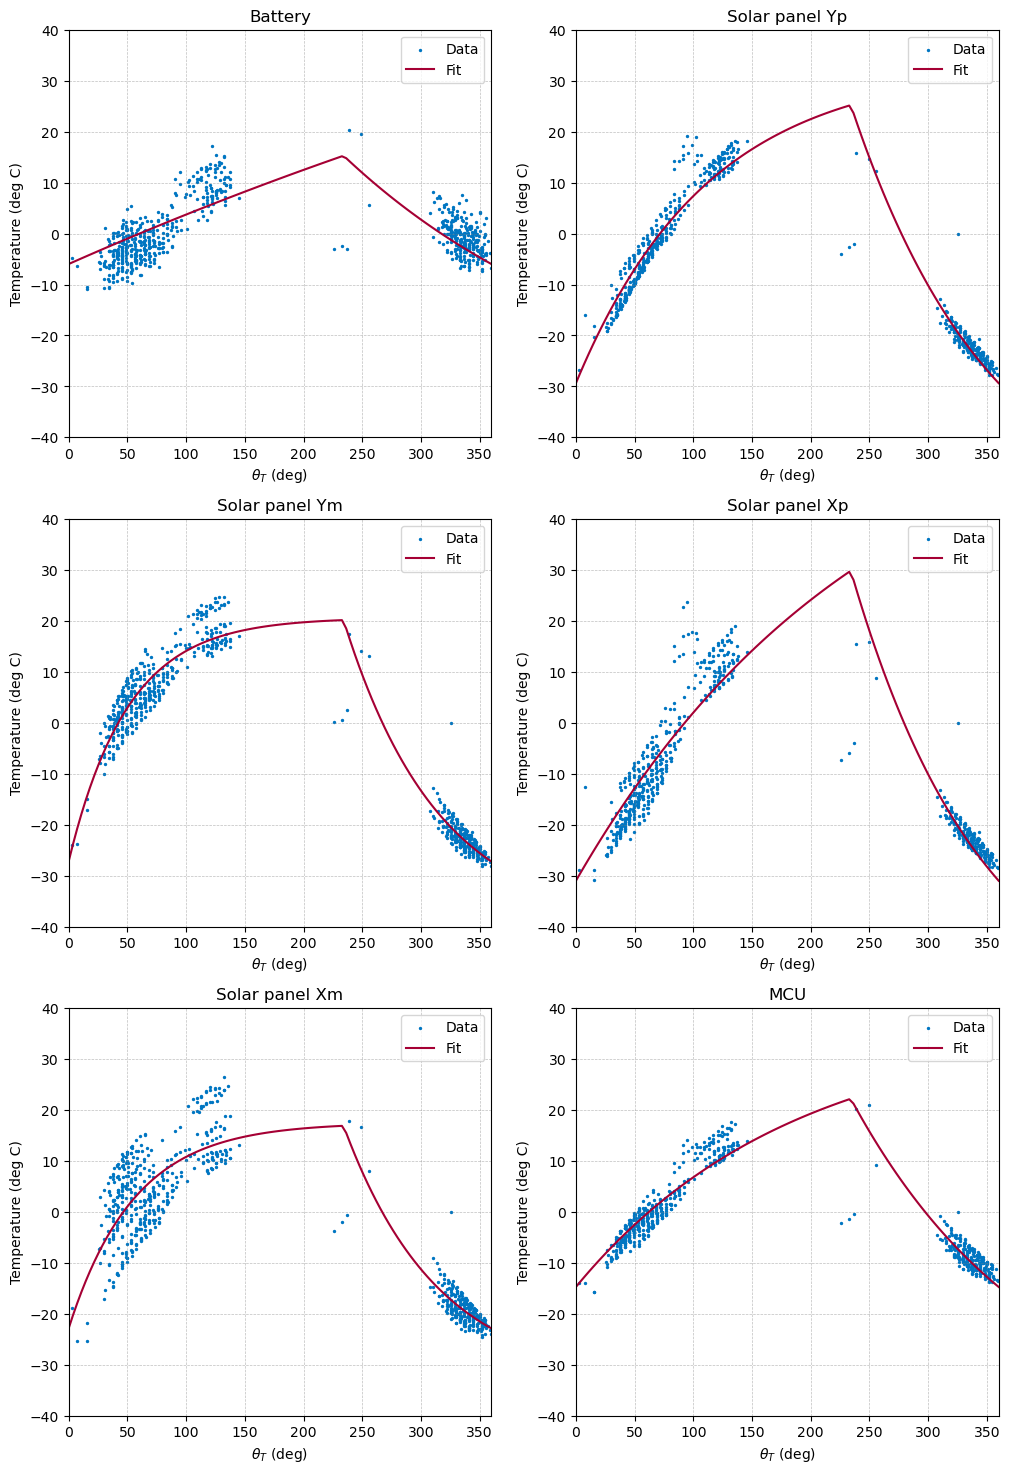

In [11]:
# # Plotting battery and MCU temperatures:
# temp_vals_data_bat_mcu = np.concatenate((telem_df.iloc[:, -6:-5], telem_df.iloc[:, -1:]), axis=1)
# temp_vals_fit_bat_mcu = np.concatenate((temp_fit[:, 0:1], temp_fit[:, -1:]), axis=1)
# theta_T_data = telem_df["theta_T (deg)"].to_numpy()
# theta_T_model = theta_T_fit

# plot_model_v2(
#     theta_T_vals=[theta_T_data, theta_T_model,],
#     temp_vals=[temp_vals_data_bat_mcu, temp_vals_fit_bat_mcu,],
#     plt_scatter=[True, False,],
#     colors=[plt_colors[0], plt_colors[1],],
#     labels=["Data", "Fit",],
#     linestyles=[None, "-",],
#     titles = ["Battery", "MCU"],
#     limit_axis=((0, 360), (-35, 40)),
# )

plot_model_v2(
    theta_T_vals=[telem_df["theta_T (deg)"].to_numpy(), theta_T_fit,],
    temp_vals=[telem_df.iloc[:, -6:].to_numpy(), temp_fit,],
    plt_scatter=[True, False,],
    colors=[plt_colors[0], plt_colors[1],],
    labels=["Data", "Fit",],
    linestyles=[None, "-",],
    titles = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    limit_axis=((0, 360), (-40, 40)),
)




In [73]:
def kde(data, bins=250, plot_kde=True, print_stats=True, return_kde=False, return_stats=False, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.

    :param data: Dataset to calculate the KDE of.
    :param bins: Number of bins to use for the KDE.
    :param plot_kde: Boolean to indicate whether to plot the KDE.
    :param print_stats: Boolean to indicate whether to print the mean and standard deviation of the KDE.
    :param return_kde: Boolean to indicate whether to return the KDE and bin centers.

    :return: If return_kde is True, the KDE and bin centers are returned.
    """


    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)
        kde[i, :] = kde_func(bin_centers[i])

    if plot_kde:
        plt.figure(figsize=(5, 5))
        plt.plot(
            bin_centers[0],
            kde[0],
            color=plt_colors[0],
            label="battery",
        )
        plt.plot(
            bin_centers[1],
            kde[1],
            color=plt_colors[1],
            label="solar panel Yp",
        )
        plt.plot(
            bin_centers[2],
            kde[2],
            color=plt_colors[2],
            label="solar panel Ym",
        )
        plt.plot(
            bin_centers[3],
            kde[3],
            color=plt_colors[3],
            label="solar panel Xp",
        )
        plt.plot(
            bin_centers[4],
            kde[4],
            color=plt_colors[4],
            label="solar panel Xm",
        )
        plt.plot(
            bin_centers[5],
            kde[5],
            color=plt_colors[5],
            label="MCU",
        )
        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density 1/$(^\circ$C)")
        if plt_title is None:
            plt.title("Kernel density estimate of the errors")
        else:
            plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    if print_stats:
        print("Battery:")
        print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
        print("Solar panel Yp:")
        print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
        print("Solar panel Ym:")
        print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
        print("Solar panel Xp:")
        print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
        print("Solar panel Xm:")
        print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
        print("MCU:")
        print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")

        print("\n")
        print("Probability of error within 1 degC:")
        error_bracket = np.empty(shape=(data.shape[1],), dtype=np.float64)
        for i in range(data.shape[1]):
            error_bracket[i] = np.trapz(kde[i][np.abs(bin_centers[i]) <= 1], bin_centers[i][np.abs(bin_centers[i]) <= 1])
        print(f"Battery: {error_bracket[0]:.2f}")
        print(f"Solar panel Yp: {error_bracket[1]:.2f}")
        print(f"Solar panel Ym: {error_bracket[2]:.2f}")
        print(f"Solar panel Xp: {error_bracket[3]:.2f}")
        print(f"Solar panel Xm: {error_bracket[4]:.2f}")
        print(f"MCU: {error_bracket[5]:.2f}")


    return_vals = []

    if return_kde:
        return_vals.append((kde, bin_centers))
    
    if return_stats:
        return_vals.append((np.mean(data, axis=0), np.std(data, axis=0), error_bracket))

    if len(return_vals) != 0:
        return return_vals

In [69]:
def model_base_curve_fit(theta_T, fit_params):
    """
    Base model to calculate the temperatures at a given theta_T
    :param theta_T: The theta_T values to calculate the temperatures for.
    :param fit_params: The fit parameters for the model.
    
    :return: Numpy array of the temperatures.
    """
    theta_T_array = np.array(theta_T, dtype=np.float64)
    temp_array = np.empty(shape=(theta_T.shape[0], 6), dtype=np.float64)

    for i in range(6):
        temp_array[:, i] = fit_function_1(theta_T_array, *fit_params[i]) - 273.15

    return temp_array

In [70]:
def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 1), output_shape=6):
    """
    Creates a model based on the given layers.
    :param layers: Dictionary of layers.
    :param optimizer: The optimizer to use.
    :param loss_function: The loss function to use.
    :param metric_function: The metric function to use.
    :param input_shape: The input shape of the model.
    :param output_shape: The output shape of the model.

    :return: The created model.
    """

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") == "relu":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation"),
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

In [71]:
# Creating training and testing datasets:
# Testing predictions without cleaning up the data further:
def normalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 6:] = (
        df.iloc[:, 6:] - min_temp
    ) / (max_temp - min_temp)

    return df

def denormalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 6:] = (
        df.iloc[:, 6:] * (max_temp - min_temp)
    ) + min_temp

    return df

# Splitting the data into training and testing sets:
train_df = telem_df.iloc[:int(0.8 * len(telem_df))].dropna(how="any").reset_index(drop=True)
test_df = telem_df.iloc[int(0.8 * len(telem_df)):].dropna(how="any").reset_index(drop=True)

# Normalizing the data:\
min_temp = np.nanmin(train_df.iloc[:, 6:].values)
max_temp = np.nanmax(train_df.iloc[:, 6:].values)

train_norm_df = normalize_datasets(train_df, min_temp, max_temp)
test_norm_df = normalize_datasets(test_df, min_temp, max_temp)

# Removing rows with any nan values:
train_norm_df = train_norm_df
test_norm_df = test_norm_df

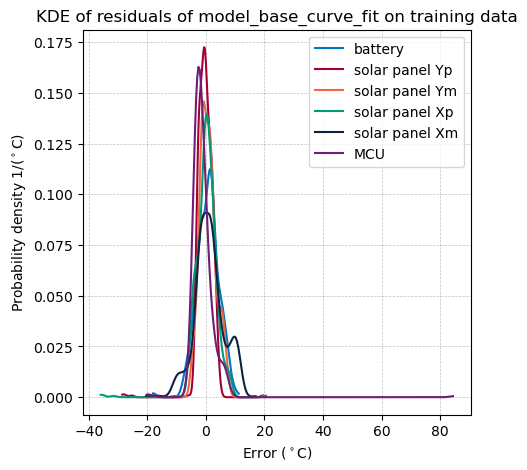

Battery:
Mean: 0.62 degC Std: 3.81 degC (area: 1.00)
Solar panel Yp:
Mean: -0.25 degC Std: 2.85 degC (area: 1.00)
Solar panel Ym:
Mean: 0.60 degC Std: 3.12 degC (area: 1.00)
Solar panel Xp:
Mean: 0.11 degC Std: 3.95 degC (area: 1.00)
Solar panel Xm:
Mean: 1.18 degC Std: 5.11 degC (area: 1.00)
MCU:
Mean: -1.16 degC Std: 4.60 degC (area: 1.00)


Probability of error within 1 degC:
Battery: 0.18
Solar panel Yp: 0.31
Solar panel Ym: 0.25
Solar panel Xp: 0.24
Solar panel Xm: 0.16
MCU: 0.17


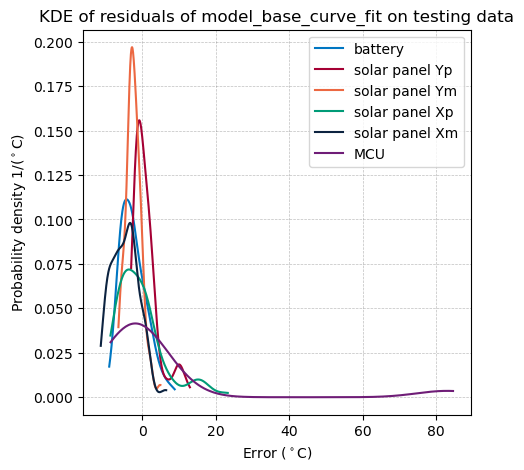

Battery:
Mean: -2.47 degC Std: 3.56 degC (area: 0.98)
Solar panel Yp:
Mean: 0.98 degC Std: 3.39 degC (area: 0.93)
Solar panel Ym:
Mean: -2.40 degC Std: 2.12 degC (area: 0.97)
Solar panel Xp:
Mean: -0.43 degC Std: 6.59 degC (area: 0.93)
Solar panel Xm:
Mean: -4.70 degC Std: 3.63 degC (area: 0.97)
MCU:
Mean: 4.65 degC Std: 22.43 degC (area: 0.77)


Probability of error within 1 degC:
Battery: 0.13
Solar panel Yp: 0.28
Solar panel Ym: 0.18
Solar panel Xp: 0.12
Solar panel Xm: 0.10
MCU: 0.06


In [74]:
# Calculating the quality of fit of model_base_curve_fit:
# Residuals of the model on the train and test datasets:
train_res = train_df.iloc[:, -6:].to_numpy() - model_base_curve_fit(train_df["theta_T (deg)"].to_numpy(), fit_params_1_np)
test_res = test_df.iloc[:, -6:].to_numpy() - model_base_curve_fit(test_df["theta_T (deg)"].to_numpy(), fit_params_1_np)

train_stats = kde(train_res, plt_title="KDE of residuals of model_base_curve_fit on training data", return_stats=True)
test_stats = kde(test_res, plt_title="KDE of residuals of model_base_curve_fit on testing data", return_stats=True)

In [15]:
def window_data_res(df, base_model_predictions, window_size):
    """
    Creates a windowed dataset for the residual model from the given dataframe.
    :param df: The dataframe to create the dataset from.
    :param base_model_predictions: The predictions of the base model.
    :param window_size: The size of the window.

    :return: The windowed dataset.
    """

    columns = np.concatenate((
        ["theta_T"],
        ["illumination"],
        ["input battery temp " + str(i) for i in range(window_size)],
        ["input solar panel Yp temp " + str(i) for i in range(window_size)],
        ["input solar panel Ym temp " + str(i) for i in range(window_size)],
        ["input solar panel Xp temp " + str(i) for i in range(window_size)],
        ["input solar panel Xm temp " + str(i) for i in range(window_size)],
        ["input MCU temp " + str(i) for i in range(window_size)],
        ["predicted battery temp"],
        ["predicted solar panel Yp temp"],
        ["predicted solar panel Ym temp"],
        ["predicted solar panel Xp temp"],
        ["predicted solar panel Xm temp"],
        ["predicted MCU temp"],
        ["output battery temp"],
        ["output solar panel Yp temp"],
        ["output solar panel Ym temp"],
        ["output solar panel Xp temp"],
        ["output solar panel Xm temp"],
        ["output MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))
    for i in range(len(window_df)):
        if df["time (jd)"][i + window_size] - df["time (jd)"][i] > window_size * 1.1 / 1440:
            continue

        window_df.loc[i, "theta_T"] = np.float64(df.loc[i + window_size, "theta_T (deg)"])
        window_df.loc[i, "illumination"] = np.int64(1 if df.loc[i + window_size, "theta_T (deg)"] < 360 * (1 - df.loc[i + window_size, "fe"]) else 0)
        for j in range(window_size):
            window_df.loc[i, "input battery temp " + str(j)] = np.float64(df.loc[i + j, "battery TMP20 temperature (deg C)"])
            window_df.loc[i, "input solar panel Yp temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Yp temperature (deg C)"])
            window_df.loc[i, "input solar panel Ym temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Ym temperature (deg C)"])
            window_df.loc[i, "input solar panel Xp temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Xp temperature (deg C)"])
            window_df.loc[i, "input solar panel Xm temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Xm temperature (deg C)"])
            window_df.loc[i, "input MCU temp " + str(j)] = np.float64(df.loc[i + j, "MCU temperature (deg C)"])

        window_df.loc[i, "predicted battery temp"] = np.float64(base_model_predictions[i + window_size][0])
        window_df.loc[i, "predicted solar panel Yp temp"] = np.float64(base_model_predictions[i + window_size, 1])
        window_df.loc[i, "predicted solar panel Ym temp"] = np.float64(base_model_predictions[i + window_size, 2])
        window_df.loc[i, "predicted solar panel Xp temp"] = np.float64(base_model_predictions[i + window_size, 3])
        window_df.loc[i, "predicted solar panel Xm temp"] = np.float64(base_model_predictions[i + window_size, 4])
        window_df.loc[i, "predicted MCU temp"] = np.float64(base_model_predictions[i + window_size][5])

        window_df.loc[i, "output battery temp"] = np.float64(df.loc[i + window_size, "battery TMP20 temperature (deg C)"])
        window_df.loc[i, "output solar panel Yp temp"] = np.float64(df.loc[i + window_size, "solar panel Yp temperature (deg C)"])
        window_df.loc[i, "output solar panel Ym temp"] = np.float64(df.loc[i + window_size, "solar panel Ym temperature (deg C)"])
        window_df.loc[i, "output solar panel Xp temp"] = np.float64(df.loc[i + window_size, "solar panel Xp temperature (deg C)"])
        window_df.loc[i, "output solar panel Xm temp"] = np.float64(df.loc[i + window_size, "solar panel Xm temperature (deg C)"])
        window_df.loc[i, "output MCU temp"] = np.float64(df.loc[i + window_size, "MCU temperature (deg C)"])

        
    return window_df

Residual models without normalizing the temperatures:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                5

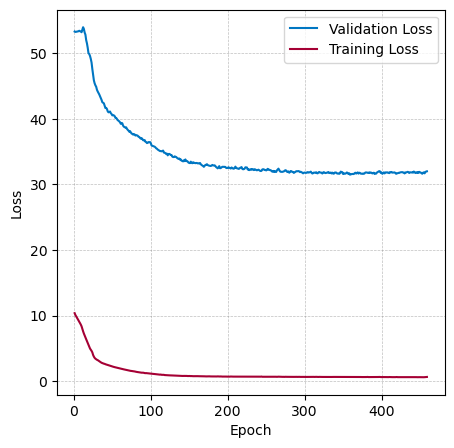

In [16]:
# Residual model with window size 1
window_size = 1
base_model_train_predictions = model_base_curve_fit(train_df["theta_T (deg)"].to_numpy(), fit_params_1_np)
train_res_1_df = window_data_res(train_df, base_model_train_predictions, window_size).dropna(how='all').reset_index(drop=True)
train_res_1_x = np.empty(shape=(len(train_res_1_df), 1 + 6 * (window_size + 1)))
train_res_1_y = np.empty(shape=(len(train_res_1_df), 6))

for i in range(len(train_res_1_df)):
    train_res_1_x[i, 0] = train_res_1_df["illumination"][i]
    train_res_1_x[i, 1:(1 + 6 * window_size)] = train_res_1_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_1_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_1_df.iloc[i, -12:-6].values

    train_res_1_y[i, 0:] = train_res_1_df.iloc[i, -6:].values - train_res_1_df.iloc[i, -12:-6].values


base_model_test_predictions = model_base_curve_fit(test_df["theta_T (deg)"].to_numpy(), fit_params_1_np)
test_res_1_df = window_data_res(test_df, base_model_test_predictions, window_size).dropna(how='all').reset_index(drop=True)
test_res_1_x = np.empty(shape=(len(test_res_1_df), 1 + 6 * (window_size + 1)))
test_res_1_y = np.empty(shape=(len(test_res_1_df), 6))

for i in range(len(test_res_1_df)):
    test_res_1_x[i, 0] = test_res_1_df["illumination"][i]
    test_res_1_x[i, 1:(1 + 6 * window_size)] = test_res_1_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_1_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_1_df.iloc[i, -12:-6].values

    test_res_1_y[i, 0:] = test_res_1_df.iloc[i, -6:].values - test_res_1_df.iloc[i, -12:-6].values


# Layers
model_res_layers = np.empty(shape=(7), dtype=dict,)
model_res_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
model_res_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
model_res_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
model_res_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
model_res_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
model_res_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
model_res_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

model_res_1, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_1.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_1 = model_res_1.fit(
        train_res_1_x,
        train_res_1_y,
        epochs=5000,
        validation_data=(test_res_1_x, test_res_1_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_1.history["loss"]), len(history_res_1.history["loss"])),
    history_res_1.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_1.history["loss"]), len(history_res_1.history["loss"])),
    history_res_1.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


3/3 [==============================] - 0s 2ms/step


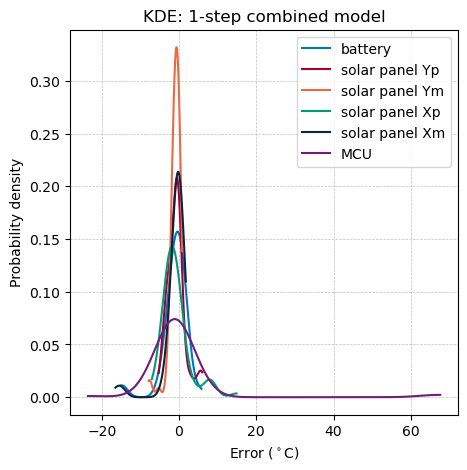

Battery:
Mean: -1.10 degC Std: 3.50 degC (area: 0.97)
Solar panel Yp:
Mean: -0.67 degC Std: 2.35 degC (area: 0.96)
Solar panel Ym:
Mean: -1.02 degC Std: 1.53 degC (area: 0.92)
Solar panel Xp:
Mean: -0.79 degC Std: 3.70 degC (area: 0.97)
Solar panel Xm:
Mean: -1.00 degC Std: 3.28 degC (area: 0.88)
MCU:
Mean: 0.52 degC Std: 11.82 degC (area: 0.98)


Probability of error within 1 degC:
Battery: 0.29
Solar panel Yp: 0.34
Solar panel Ym: 0.50
Solar panel Xp: 0.21
Solar panel Xm: 0.38
MCU: 0.13


In [17]:

# Checking the errors from the model:
predicted_res_1 = model_res_1.predict(test_res_1_x)
predicted_temps = test_res_1_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_1
actual_temps = test_res_1_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_1_stats = kde(residuals, plt_title="KDE: 1-step combined model", return_stats=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               5120      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)               

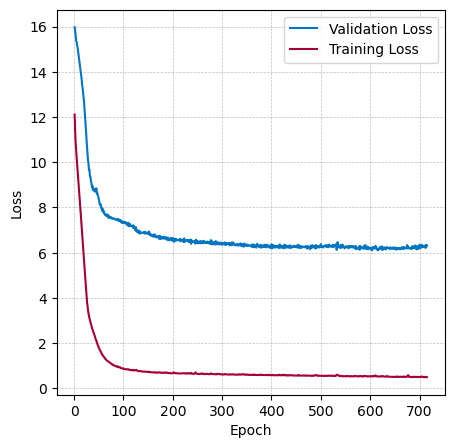

In [18]:
# Residual model with window_size = 2
window_size = 2
train_res_2_df = window_data_res(train_df, base_model_train_predictions, window_size).dropna(how='all').reset_index(drop=True)
train_res_2_x = np.empty(shape=(len(train_res_2_df), 1 + 6 * (window_size + 1)))
train_res_2_y = np.empty(shape=(len(train_res_2_df), 6))

for i in range(len(train_res_2_df)):
    train_res_2_x[i, 0] = train_res_2_df["illumination"][i]
    train_res_2_x[i, 1:(1 + 6 * window_size)] = train_res_2_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_2_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_2_df.iloc[i, -12:-6].values

    train_res_2_y[i, 0:] = train_res_2_df.iloc[i, -6:].values - train_res_2_df.iloc[i, -12:-6].values

test_res_2_df = window_data_res(test_df, base_model_test_predictions, window_size).dropna(how='all').reset_index(drop=True)
test_res_2_x = np.empty(shape=(len(test_res_2_df), 1 + 6 * (window_size + 1)))
test_res_2_y = np.empty(shape=(len(test_res_2_df), 6))

for i in range(len(test_res_2_df)):
    test_res_2_x[i, 0] = test_res_2_df["illumination"][i]
    test_res_2_x[i, 1:(1 + 6 * window_size)] = test_res_2_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_2_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_2_df.iloc[i, -12:-6].values

    test_res_2_y[i, 0:] = test_res_2_df.iloc[i, -6:].values - test_res_2_df.iloc[i, -12:-6].values

model_res_2, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_2.summary()

with tf.device(recommended_device):
    history_res_2 = model_res_2.fit(
        train_res_2_x,
        train_res_2_y,
        epochs=5000,
        validation_data=(test_res_2_x, test_res_2_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_2.history["loss"]), len(history_res_2.history["loss"])),
    history_res_2.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_2.history["loss"]), len(history_res_2.history["loss"])),
    history_res_2.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


2/2 [==============================] - 0s 3ms/step


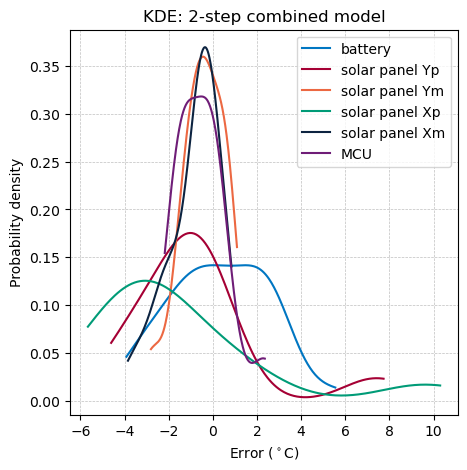

Battery:
Mean: 0.30 degC Std: 2.20 degC (area: 0.94)
Solar panel Yp:
Mean: -0.71 degC Std: 2.89 degC (area: 0.89)
Solar panel Ym:
Mean: -0.45 degC Std: 0.96 degC (area: 0.91)
Solar panel Xp:
Mean: -1.46 degC Std: 4.00 degC (area: 0.84)
Solar panel Xm:
Mean: -0.86 degC Std: 1.15 degC (area: 0.91)
MCU:
Mean: -0.52 degC Std: 1.10 degC (area: 0.90)


Probability of error within 1 degC:
Battery: 0.28
Solar panel Yp: 0.29
Solar panel Ym: 0.63
Solar panel Xp: 0.15
Solar panel Xm: 0.55
MCU: 0.52


In [19]:

# Checking the errors from the model:
predicted_res_2 = model_res_2.predict(test_res_2_x)
predicted_temps = test_res_2_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_2
actual_temps = test_res_2_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_2_stats = kde(residuals, plt_title="KDE: 2-step combined model", return_stats=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               6656      
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 16)               

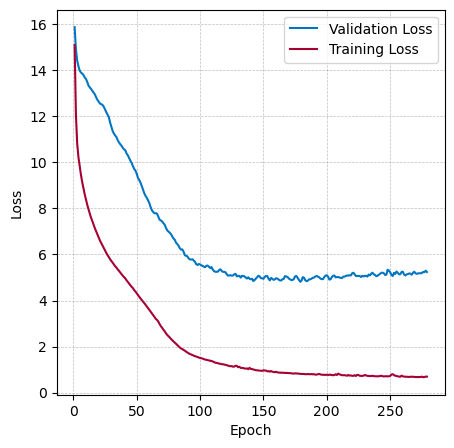

In [20]:
# Residual model with window_size = 3
window_size = 3
train_res_3_df = window_data_res(train_df, base_model_train_predictions, window_size).dropna(how='all').reset_index(drop=True)
train_res_3_x = np.empty(shape=(len(train_res_3_df), 1 + 6 * (window_size + 1)))
train_res_3_y = np.empty(shape=(len(train_res_3_df), 6))

for i in range(len(train_res_3_df)):
    train_res_3_x[i, 0] = train_res_3_df["illumination"][i]
    train_res_3_x[i, 1:(1 + 6 * window_size)] = train_res_3_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_3_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_3_df.iloc[i, -12:-6].values

    train_res_3_y[i, 0:] = train_res_3_df.iloc[i, -6:].values - train_res_3_df.iloc[i, -12:-6].values

test_res_3_df = window_data_res(test_df, base_model_test_predictions, window_size).dropna(how='all').reset_index(drop=True)
test_res_3_x = np.empty(shape=(len(test_res_3_df), 1 + 6 * (window_size + 1)))
test_res_3_y = np.empty(shape=(len(test_res_3_df), 6))

for i in range(len(test_res_3_df)):
    test_res_3_x[i, 0] = test_res_3_df["illumination"][i]
    test_res_3_x[i, 1:(1 + 6 * window_size)] = test_res_3_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_3_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_3_df.iloc[i, -12:-6].values

    test_res_3_y[i, 0:] = test_res_3_df.iloc[i, -6:].values - test_res_3_df.iloc[i, -12:-6].values

model_res_3, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_3.summary()

with tf.device(recommended_device):
    history_res_3 = model_res_3.fit(
        train_res_3_x,
        train_res_3_y,
        epochs=5000,
        validation_data=(test_res_3_x, test_res_3_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_3.history["loss"]), len(history_res_3.history["loss"])),
    history_res_3.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_3.history["loss"]), len(history_res_3.history["loss"])),
    history_res_3.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 89ms/step


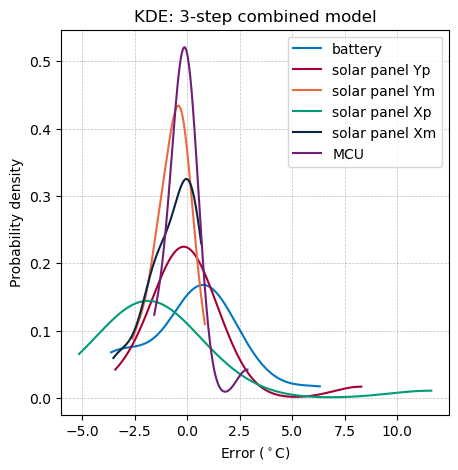

Battery:
Mean: 0.20 degC Std: 2.47 degC (area: 0.87)
Solar panel Yp:
Mean: 0.17 degC Std: 2.27 degC (area: 0.93)
Solar panel Ym:
Mean: -0.71 degC Std: 0.85 degC (area: 0.91)
Solar panel Xp:
Mean: -1.12 degC Std: 3.51 degC (area: 0.87)
Solar panel Xm:
Mean: -0.76 degC Std: 1.16 degC (area: 0.83)
MCU:
Mean: -0.12 degC Std: 0.91 degC (area: 0.91)


Probability of error within 1 degC:
Battery: 0.29
Solar panel Yp: 0.41
Solar panel Ym: 0.60
Solar panel Xp: 0.21
Solar panel Xm: 0.49
MCU: 0.75


In [21]:

# Checking the errors from the model:
predicted_res_3 = model_res_3.predict(test_res_3_x)
predicted_temps = test_res_3_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_3
actual_temps = test_res_3_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_3_stats = kde(residuals, plt_title="KDE: 3-step combined model", return_stats=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               8192      
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 16)               

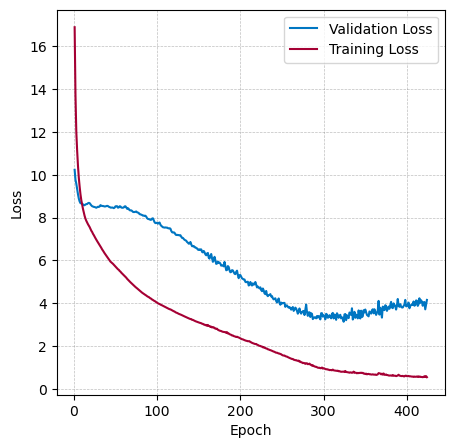

In [22]:
# Residual model with window_size = 4
window_size = 4
train_res_4_df = window_data_res(train_df, base_model_train_predictions, window_size).dropna(how='all').reset_index(drop=True)
train_res_4_x = np.empty(shape=(len(train_res_4_df), 1 + 6 * (window_size + 1)))
train_res_4_y = np.empty(shape=(len(train_res_4_df), 6))

for i in range(len(train_res_4_df)):
    train_res_4_x[i, 0] = train_res_4_df["illumination"][i]
    train_res_4_x[i, 1:(1 + 6 * window_size)] = train_res_4_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_4_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_4_df.iloc[i, -12:-6].values

    train_res_4_y[i, 0:] = train_res_4_df.iloc[i, -6:].values - train_res_4_df.iloc[i, -12:-6].values

test_res_4_df = window_data_res(test_df, base_model_test_predictions, window_size).dropna(how='all').reset_index(drop=True)
test_res_4_x = np.empty(shape=(len(test_res_4_df), 1 + 6 * (window_size + 1)))
test_res_4_y = np.empty(shape=(len(test_res_4_df), 6))

for i in range(len(test_res_4_df)):
    test_res_4_x[i, 0] = test_res_4_df["illumination"][i]
    test_res_4_x[i, 1:(1 + 6 * window_size)] = test_res_4_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_4_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_4_df.iloc[i, -12:-6].values

    test_res_4_y[i, 0:] = test_res_4_df.iloc[i, -6:].values - test_res_4_df.iloc[i, -12:-6].values

model_res_4, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_4.summary()

with tf.device(recommended_device):
    history_res_4 = model_res_4.fit(
        train_res_4_x,
        train_res_4_y,
        epochs=5000,
        validation_data=(test_res_4_x, test_res_4_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_4.history["loss"]), len(history_res_4.history["loss"])),
    history_res_4.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_4.history["loss"]), len(history_res_4.history["loss"])),
    history_res_4.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 98ms/step


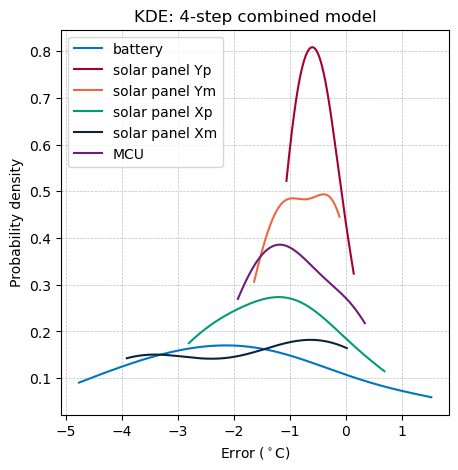

Battery:
Mean: -1.93 degC Std: 1.89 degC (area: 0.81)
Solar panel Yp:
Mean: -0.53 degC Std: 0.38 degC (area: 0.78)
Solar panel Ym:
Mean: -0.77 degC Std: 0.55 degC (area: 0.70)
Solar panel Xp:
Mean: -1.24 degC Std: 1.11 degC (area: 0.77)
Solar panel Xm:
Mean: -1.86 degC Std: 1.62 degC (area: 0.62)
MCU:
Mean: -0.87 degC Std: 0.77 degC (area: 0.74)


Probability of error within 1 degC:
Battery: 0.22
Solar panel Yp: 0.75
Solar panel Ym: 0.43
Solar panel Xp: 0.34
Solar panel Xm: 0.18
MCU: 0.41


In [23]:

# Checking the errors from the model:
predicted_res_4 = model_res_4.predict(test_res_4_x)
predicted_temps = test_res_4_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_4
actual_temps = test_res_4_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_4_stats = kde(residuals, plt_title="KDE: 4-step combined model", return_stats=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 256)               9728      
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
 dense_35 (Dense)            (None, 128)               16512     
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 16)               

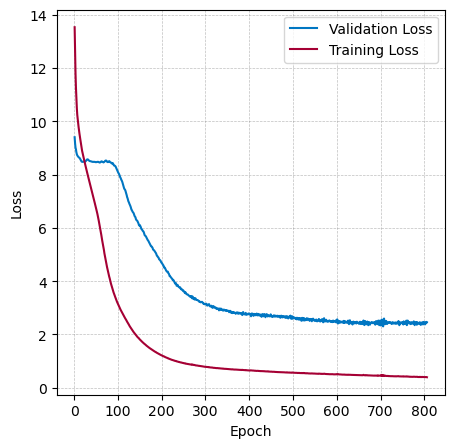

In [24]:
# Residual model with window_size = 5
window_size = 5
train_res_5_df = window_data_res(train_df, base_model_train_predictions, window_size).dropna(how='all').reset_index(drop=True)
train_res_5_x = np.empty(shape=(len(train_res_5_df), 1 + 6 * (window_size + 1)))
train_res_5_y = np.empty(shape=(len(train_res_5_df), 6))

for i in range(len(train_res_5_df)):
    train_res_5_x[i, 0] = train_res_5_df["illumination"][i]
    train_res_5_x[i, 1:(1 + 6 * window_size)] = train_res_5_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_5_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_5_df.iloc[i, -12:-6].values

    train_res_5_y[i, 0:] = train_res_5_df.iloc[i, -6:].values - train_res_5_df.iloc[i, -12:-6].values

test_res_5_df = window_data_res(test_df, base_model_test_predictions, window_size).dropna(how='all').reset_index(drop=True)
test_res_5_x = np.empty(shape=(len(test_res_5_df), 1 + 6 * (window_size + 1)))
test_res_5_y = np.empty(shape=(len(test_res_5_df), 6))

for i in range(len(test_res_5_df)):
    test_res_5_x[i, 0] = test_res_5_df["illumination"][i]
    test_res_5_x[i, 1:(1 + 6 * window_size)] = test_res_5_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_5_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_5_df.iloc[i, -12:-6].values

    test_res_5_y[i, 0:] = test_res_5_df.iloc[i, -6:].values - test_res_5_df.iloc[i, -12:-6].values

model_res_5, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_5.summary()

with tf.device(recommended_device):
    history_res_5 = model_res_5.fit(
        train_res_5_x,
        train_res_5_y,
        epochs=5000,
        validation_data=(test_res_5_x, test_res_5_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_5.history["loss"]), len(history_res_5.history["loss"])),
    history_res_5.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_5.history["loss"]), len(history_res_5.history["loss"])),
    history_res_5.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 96ms/step


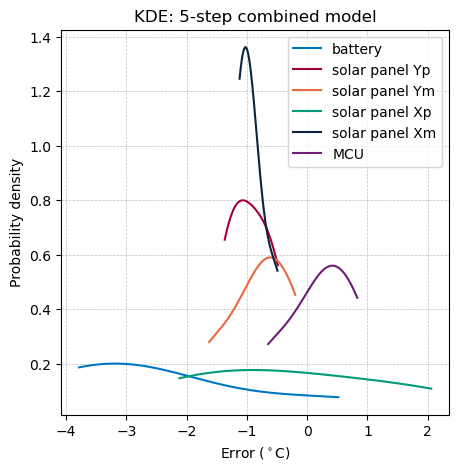

Battery:
Mean: -2.31 degC Std: 1.67 degC (area: 0.60)
Solar panel Yp:
Mean: -0.95 degC Std: 0.34 degC (area: 0.65)
Solar panel Ym:
Mean: -0.81 degC Std: 0.52 degC (area: 0.67)
Solar panel Xp:
Mean: -0.25 degC Std: 1.58 degC (area: 0.65)
Solar panel Xm:
Mean: -0.90 degC Std: 0.24 degC (area: 0.61)
MCU:
Mean: 0.20 degC Std: 0.54 degC (area: 0.67)


Probability of error within 1 degC:
Battery: 0.13
Solar panel Yp: 0.36
Solar panel Ym: 0.44
Solar panel Xp: 0.33
Solar panel Xm: 0.45
MCU: 0.67


In [25]:

# Checking the errors from the model:
predicted_res_5 = model_res_5.predict(test_res_5_x)
predicted_temps = test_res_5_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_5
actual_temps = test_res_5_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_5_stats = kde(residuals, plt_title="KDE: 5-step combined model", return_stats=True)

Residual models with normalization:

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               3584      
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dense_43 (Dense)            (None, 128)               16512     
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 16)               

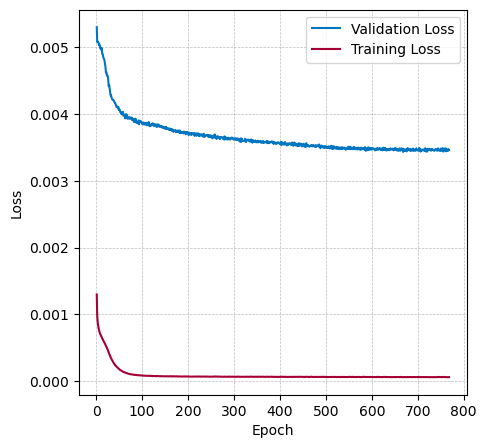

In [26]:
# Residual model with window size=1
window_size = 1
base_model_train_predictions_norm = (model_base_curve_fit(train_norm_df["theta_T (deg)"].to_numpy(), fit_params_1_np) - min_temp) / (max_temp - min_temp)
train_res_1_norm_df = window_data_res(train_norm_df, base_model_train_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
train_res_1_norm_x = np.empty(shape=(len(train_res_1_norm_df), 1 + 6 * (window_size + 1)))
train_res_1_norm_y = np.empty(shape=(len(train_res_1_norm_df), 6))

for i in range(len(train_res_1_norm_df)):
    train_res_1_norm_x[i, 0] = train_res_1_norm_df["illumination"][i]
    train_res_1_norm_x[i, 1:(1 + 6 * window_size)] = train_res_1_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_1_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_1_norm_df.iloc[i, -12:-6].values

    train_res_1_norm_y[i, 0:] = train_res_1_norm_df.iloc[i, -6:].values - train_res_1_norm_df.iloc[i, -12:-6].values


base_model_test_predictions_norm = (model_base_curve_fit(test_norm_df["theta_T (deg)"].to_numpy(), fit_params_1_np) - min_temp) / (max_temp - min_temp)
test_res_1_norm_df = window_data_res(test_norm_df, base_model_test_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
test_res_1_norm_x = np.empty(shape=(len(test_res_1_norm_df), 1 + 6 * (window_size + 1)))
test_res_1_norm_y = np.empty(shape=(len(test_res_1_norm_df), 6))

for i in range(len(test_res_1_norm_df)):
    test_res_1_norm_x[i, 0] = test_res_1_norm_df["illumination"][i]
    test_res_1_norm_x[i, 1:(1 + 6 * window_size)] = test_res_1_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_1_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_1_norm_df.iloc[i, -12:-6].values

    test_res_1_norm_y[i, 0:] = test_res_1_norm_df.iloc[i, -6:].values - test_res_1_norm_df.iloc[i, -12:-6].values

# Layers
model_res_layers = np.empty(shape=(7), dtype=dict,)
model_res_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
model_res_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
model_res_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
model_res_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
model_res_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
model_res_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
model_res_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

model_res_1_norm, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_1_norm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_1_norm = model_res_1_norm.fit(
        train_res_1_norm_x,
        train_res_1_norm_y,
        epochs=5000,
        validation_data=(test_res_1_norm_x, test_res_1_norm_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_1_norm.history["loss"]), len(history_res_1_norm.history["loss"])),
    history_res_1_norm.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_1_norm.history["loss"]), len(history_res_1_norm.history["loss"])),
    history_res_1_norm.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


3/3 [==============================] - 0s 3ms/step


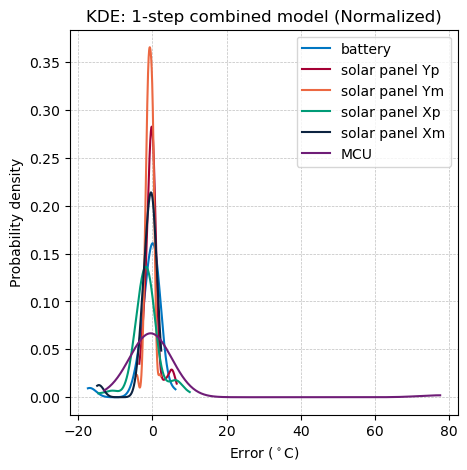

Battery:
Mean: -0.79 degC Std: 3.89 degC (area: 0.97)
Solar panel Yp:
Mean: 0.03 degC Std: 1.94 degC (area: 0.97)
Solar panel Ym:
Mean: -0.72 degC Std: 1.09 degC (area: 0.98)
Solar panel Xp:
Mean: -1.50 degC Std: 3.85 degC (area: 0.98)
Solar panel Xm:
Mean: -1.21 degC Std: 3.03 degC (area: 0.95)
MCU:
Mean: 1.61 degC Std: 13.14 degC (area: 0.97)


Probability of error within 1 degC:
Battery: 0.30
Solar panel Yp: 0.49
Solar panel Ym: 0.55
Solar panel Xp: 0.21
Solar panel Xm: 0.39
MCU: 0.12


In [27]:

# Checking the errors from the model:
predicted_res_1_norm = model_res_1_norm.predict(test_res_1_norm_x)
predicted_temps = (test_res_1_norm_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_1_norm) * (max_temp - min_temp) + min_temp
actual_temps = (test_res_1_norm_df.iloc[:, -6:].to_numpy(dtype=np.float64)) * (max_temp - min_temp) + min_temp

residuals = actual_temps - predicted_temps
res_1_norm_stats = kde(residuals, plt_title="KDE: 1-step combined model (Normalized)", return_stats=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               5120      
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                                 
 dense_51 (Dense)            (None, 128)               16512     
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dense_54 (Dense)            (None, 16)               

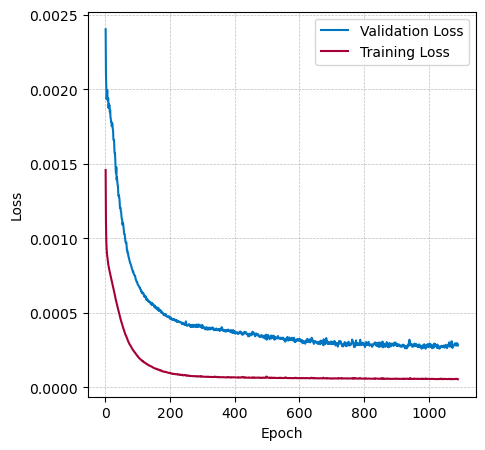

In [28]:
# Residual model with window size=2
window_size = 2
train_res_2_norm_df = window_data_res(train_norm_df, base_model_train_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
train_res_2_norm_x = np.empty(shape=(len(train_res_2_norm_df), 1 + 6 * (window_size + 1)))
train_res_2_norm_y = np.empty(shape=(len(train_res_2_norm_df), 6))

for i in range(len(train_res_2_norm_df)):
    train_res_2_norm_x[i, 0] = train_res_2_norm_df["illumination"][i]
    train_res_2_norm_x[i, 1:(1 + 6 * window_size)] = train_res_2_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_2_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_2_norm_df.iloc[i, -12:-6].values

    train_res_2_norm_y[i, 0:] = train_res_2_norm_df.iloc[i, -6:].values - train_res_2_norm_df.iloc[i, -12:-6].values


test_res_2_norm_df = window_data_res(test_norm_df, base_model_test_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
test_res_2_norm_x = np.empty(shape=(len(test_res_2_norm_df), 1 + 6 * (window_size + 1)))
test_res_2_norm_y = np.empty(shape=(len(test_res_2_norm_df), 6))

for i in range(len(test_res_2_norm_df)):
    test_res_2_norm_x[i, 0] = test_res_2_norm_df["illumination"][i]
    test_res_2_norm_x[i, 1:(1 + 6 * window_size)] = test_res_2_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_2_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_2_norm_df.iloc[i, -12:-6].values

    test_res_2_norm_y[i, 0:] = test_res_2_norm_df.iloc[i, -6:].values - test_res_2_norm_df.iloc[i, -12:-6].values


model_res_2_norm, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_2_norm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_2_norm = model_res_2_norm.fit(
        train_res_2_norm_x,
        train_res_2_norm_y,
        epochs=5000,
        validation_data=(test_res_2_norm_x, test_res_2_norm_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_2_norm.history["loss"]), len(history_res_2_norm.history["loss"])),
    history_res_2_norm.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_2_norm.history["loss"]), len(history_res_2_norm.history["loss"])),
    history_res_2_norm.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


2/2 [==============================] - 0s 4ms/step


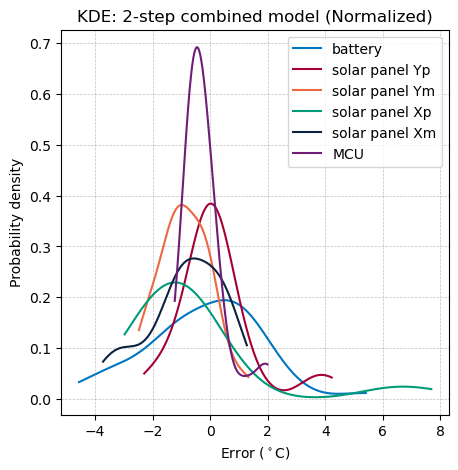

Battery:
Mean: -0.21 degC Std: 1.98 degC (area: 0.96)
Solar panel Yp:
Mean: 0.22 degC Std: 1.36 degC (area: 0.94)
Solar panel Ym:
Mean: -0.89 degC Std: 0.90 degC (area: 0.92)
Solar panel Xp:
Mean: -0.53 degC Std: 2.46 degC (area: 0.85)
Solar panel Xm:
Mean: -0.88 degC Std: 1.33 degC (area: 0.91)
MCU:
Mean: -0.21 degC Std: 0.71 degC (area: 0.93)


Probability of error within 1 degC:
Battery: 0.36
Solar panel Yp: 0.62
Solar panel Ym: 0.50
Solar panel Xp: 0.32
Solar panel Xm: 0.49
MCU: 0.80


In [29]:

# Checking the errors from the model:
predicted_res_2_norm = model_res_2_norm.predict(test_res_2_norm_x)
predicted_temps = (test_res_2_norm_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_2_norm) * (max_temp - min_temp) + min_temp
actual_temps = (test_res_2_norm_df.iloc[:, -6:].to_numpy(dtype=np.float64)) * (max_temp - min_temp) + min_temp

residuals = actual_temps - predicted_temps
res_2_norm_stats = kde(residuals, plt_title="KDE: 2-step combined model (Normalized)", return_stats=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               6656      
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dense_58 (Dense)            (None, 128)               32896     
                                                                 
 dense_59 (Dense)            (None, 128)               16512     
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dense_62 (Dense)            (None, 16)               

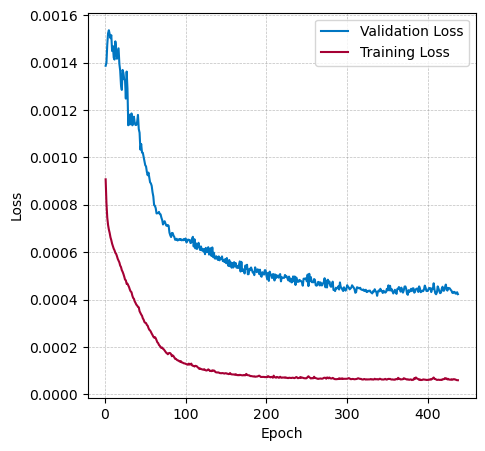

In [30]:
# Residual model with window size=2
window_size = 3
train_res_3_norm_df = window_data_res(train_norm_df, base_model_train_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
train_res_3_norm_x = np.empty(shape=(len(train_res_3_norm_df), 1 + 6 * (window_size + 1)))
train_res_3_norm_y = np.empty(shape=(len(train_res_3_norm_df), 6))

for i in range(len(train_res_3_norm_df)):
    train_res_3_norm_x[i, 0] = train_res_3_norm_df["illumination"][i]
    train_res_3_norm_x[i, 1:(1 + 6 * window_size)] = train_res_3_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_3_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_3_norm_df.iloc[i, -12:-6].values

    train_res_3_norm_y[i, 0:] = train_res_3_norm_df.iloc[i, -6:].values - train_res_3_norm_df.iloc[i, -12:-6].values


test_res_3_norm_df = window_data_res(test_norm_df, base_model_test_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
test_res_3_norm_x = np.empty(shape=(len(test_res_3_norm_df), 1 + 6 * (window_size + 1)))
test_res_3_norm_y = np.empty(shape=(len(test_res_3_norm_df), 6))

for i in range(len(test_res_3_norm_df)):
    test_res_3_norm_x[i, 0] = test_res_3_norm_df["illumination"][i]
    test_res_3_norm_x[i, 1:(1 + 6 * window_size)] = test_res_3_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_3_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_3_norm_df.iloc[i, -12:-6].values

    test_res_3_norm_y[i, 0:] = test_res_3_norm_df.iloc[i, -6:].values - test_res_3_norm_df.iloc[i, -12:-6].values


model_res_3_norm, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_3_norm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_3_norm = model_res_3_norm.fit(
        train_res_3_norm_x,
        train_res_3_norm_y,
        epochs=5000,
        validation_data=(test_res_3_norm_x, test_res_3_norm_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_3_norm.history["loss"]), len(history_res_3_norm.history["loss"])),
    history_res_3_norm.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_3_norm.history["loss"]), len(history_res_3_norm.history["loss"])),
    history_res_3_norm.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 87ms/step


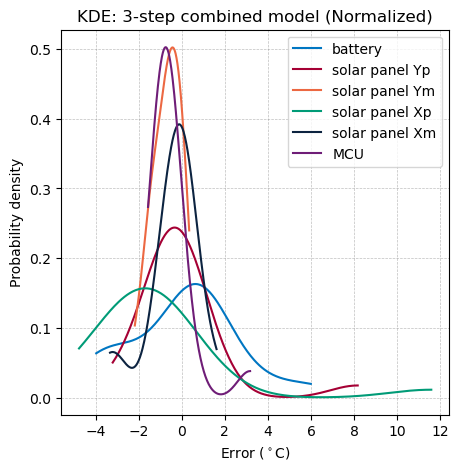

Battery:
Mean: 0.08 degC Std: 2.48 degC (area: 0.88)
Solar panel Yp:
Mean: 0.02 degC Std: 2.20 degC (area: 0.92)
Solar panel Ym:
Mean: -0.71 degC Std: 0.66 degC (area: 0.89)
Solar panel Xp:
Mean: -1.04 degC Std: 3.36 degC (area: 0.87)
Solar panel Xm:
Mean: -0.42 degC Std: 1.17 degC (area: 0.91)
MCU:
Mean: -0.51 degC Std: 1.01 degC (area: 0.85)


Probability of error within 1 degC:
Battery: 0.29
Solar panel Yp: 0.44
Solar panel Ym: 0.58
Solar panel Xp: 0.23
Solar panel Xm: 0.64
MCU: 0.59


In [31]:

# Checking the errors from the model:
predicted_res_3_norm = model_res_3_norm.predict(test_res_3_norm_x)
predicted_temps = (test_res_3_norm_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_3_norm) * (max_temp - min_temp) + min_temp
actual_temps = (test_res_3_norm_df.iloc[:, -6:].to_numpy(dtype=np.float64)) * (max_temp - min_temp) + min_temp

residuals = actual_temps - predicted_temps
res_3_norm_stats = kde(residuals, plt_title="KDE: 3-step combined model (Normalized)", return_stats=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 256)               8192      
                                                                 
 dense_65 (Dense)            (None, 256)               65792     
                                                                 
 dense_66 (Dense)            (None, 128)               32896     
                                                                 
 dense_67 (Dense)            (None, 128)               16512     
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 32)                2080      
                                                                 
 dense_70 (Dense)            (None, 16)               

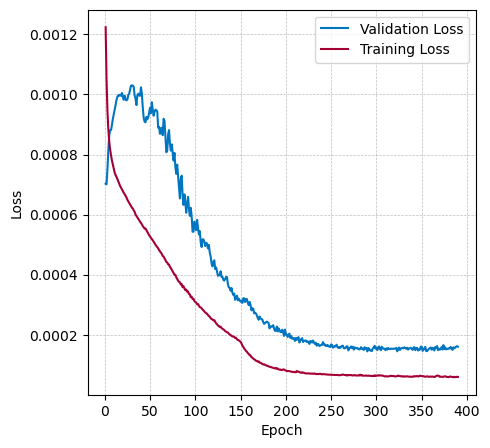

In [32]:
# Residual model with window size=2
window_size = 4
train_res_4_norm_df = window_data_res(train_norm_df, base_model_train_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
train_res_4_norm_x = np.empty(shape=(len(train_res_4_norm_df), 1 + 6 * (window_size + 1)))
train_res_4_norm_y = np.empty(shape=(len(train_res_4_norm_df), 6))

for i in range(len(train_res_4_norm_df)):
    train_res_4_norm_x[i, 0] = train_res_4_norm_df["illumination"][i]
    train_res_4_norm_x[i, 1:(1 + 6 * window_size)] = train_res_4_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_4_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_4_norm_df.iloc[i, -12:-6].values

    train_res_4_norm_y[i, 0:] = train_res_4_norm_df.iloc[i, -6:].values - train_res_4_norm_df.iloc[i, -12:-6].values


test_res_4_norm_df = window_data_res(test_norm_df, base_model_test_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
test_res_4_norm_x = np.empty(shape=(len(test_res_4_norm_df), 1 + 6 * (window_size + 1)))
test_res_4_norm_y = np.empty(shape=(len(test_res_4_norm_df), 6))

for i in range(len(test_res_4_norm_df)):
    test_res_4_norm_x[i, 0] = test_res_4_norm_df["illumination"][i]
    test_res_4_norm_x[i, 1:(1 + 6 * window_size)] = test_res_4_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_4_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_4_norm_df.iloc[i, -12:-6].values

    test_res_4_norm_y[i, 0:] = test_res_4_norm_df.iloc[i, -6:].values - test_res_4_norm_df.iloc[i, -12:-6].values


model_res_4_norm, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_4_norm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_4_norm = model_res_4_norm.fit(
        train_res_4_norm_x,
        train_res_4_norm_y,
        epochs=5000,
        validation_data=(test_res_4_norm_x, test_res_4_norm_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_4_norm.history["loss"]), len(history_res_4_norm.history["loss"])),
    history_res_4_norm.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_4_norm.history["loss"]), len(history_res_4_norm.history["loss"])),
    history_res_4_norm.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 89ms/step


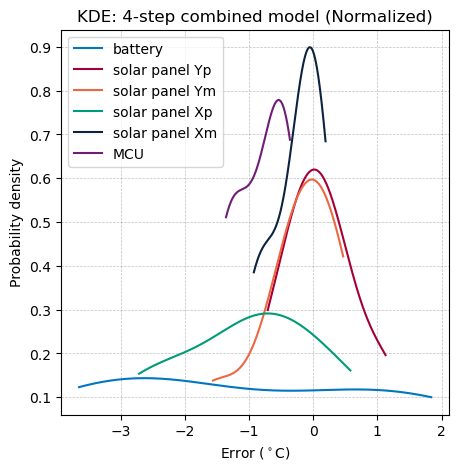

Battery:
Mean: -1.11 degC Std: 2.05 degC (area: 0.68)
Solar panel Yp:
Mean: 0.12 degC Std: 0.54 degC (area: 0.82)
Solar panel Ym:
Mean: -0.25 degC Std: 0.62 degC (area: 0.76)
Solar panel Xp:
Mean: -1.04 degC Std: 1.07 degC (area: 0.77)
Solar panel Xm:
Mean: -0.27 degC Std: 0.38 degC (area: 0.73)
MCU:
Mean: -0.82 degC Std: 0.39 degC (area: 0.65)


Probability of error within 1 degC:
Battery: 0.23
Solar panel Yp: 0.79
Solar panel Ym: 0.67
Solar panel Xp: 0.39
Solar panel Xm: 0.73
MCU: 0.45


In [33]:

# Checking the errors from the model:
predicted_res_4_norm = model_res_4_norm.predict(test_res_4_norm_x)
predicted_temps = (test_res_4_norm_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_4_norm) * (max_temp - min_temp) + min_temp
actual_temps = (test_res_4_norm_df.iloc[:, -6:].to_numpy(dtype=np.float64)) * (max_temp - min_temp) + min_temp

residuals = actual_temps - predicted_temps
res_4_norm_stats = kde(residuals, plt_title="KDE: 4-step combined model (Normalized)", return_stats=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               9728      
                                                                 
 dense_73 (Dense)            (None, 256)               65792     
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 dense_75 (Dense)            (None, 128)               16512     
                                                                 
 dense_76 (Dense)            (None, 64)                8256      
                                                                 
 dense_77 (Dense)            (None, 32)                2080      
                                                                 
 dense_78 (Dense)            (None, 16)               

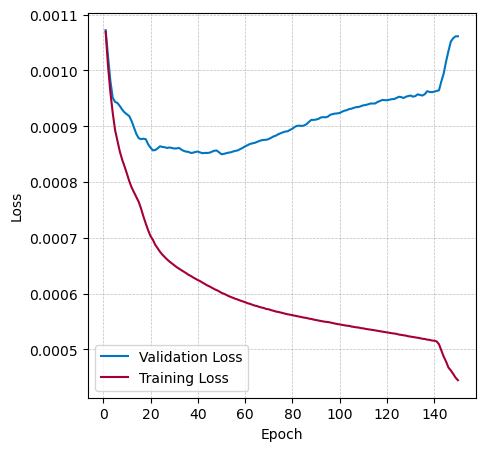

In [34]:
# Residual model with window size=5
window_size = 5
train_res_5_norm_df = window_data_res(train_norm_df, base_model_train_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
train_res_5_norm_x = np.empty(shape=(len(train_res_5_norm_df), 1 + 6 * (window_size + 1)))
train_res_5_norm_y = np.empty(shape=(len(train_res_5_norm_df), 6))

for i in range(len(train_res_5_norm_df)):
    train_res_5_norm_x[i, 0] = train_res_5_norm_df["illumination"][i]
    train_res_5_norm_x[i, 1:(1 + 6 * window_size)] = train_res_5_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_5_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_5_norm_df.iloc[i, -12:-6].values

    train_res_5_norm_y[i, 0:] = train_res_5_norm_df.iloc[i, -6:].values - train_res_5_norm_df.iloc[i, -12:-6].values


test_res_5_norm_df = window_data_res(test_norm_df, base_model_test_predictions_norm, window_size).dropna(how='all').reset_index(drop=True)
test_res_5_norm_x = np.empty(shape=(len(test_res_5_norm_df), 1 + 6 * (window_size + 1)))
test_res_5_norm_y = np.empty(shape=(len(test_res_5_norm_df), 6))

for i in range(len(test_res_5_norm_df)):
    test_res_5_norm_x[i, 0] = test_res_5_norm_df["illumination"][i]
    test_res_5_norm_x[i, 1:(1 + 6 * window_size)] = test_res_5_norm_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_5_norm_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_5_norm_df.iloc[i, -12:-6].values

    test_res_5_norm_y[i, 0:] = test_res_5_norm_df.iloc[i, -6:].values - test_res_5_norm_df.iloc[i, -12:-6].values


model_res_5_norm, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_5_norm.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device(recommended_device):
    history_res_5_norm = model_res_5_norm.fit(
        train_res_5_norm_x,
        train_res_5_norm_y,
        epochs=5000,
        validation_data=(test_res_5_norm_x, test_res_5_norm_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_5_norm.history["loss"]), len(history_res_5_norm.history["loss"])),
    history_res_5_norm.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_5_norm.history["loss"]), len(history_res_5_norm.history["loss"])),
    history_res_5_norm.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 0s 84ms/step


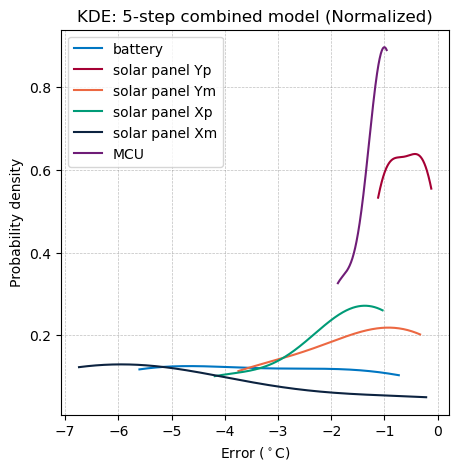

Battery:
Mean: -3.35 degC Std: 2.06 degC (area: 0.58)
Solar panel Yp:
Mean: -0.61 degC Std: 0.40 degC (area: 0.61)
Solar panel Ym:
Mean: -1.64 degC Std: 1.36 degC (area: 0.60)
Solar panel Xp:
Mean: -2.05 degC Std: 1.25 degC (area: 0.57)
Solar panel Xm:
Mean: -4.57 degC Std: 2.57 degC (area: 0.58)
MCU:
Mean: -1.21 degC Std: 0.38 degC (area: 0.53)


Probability of error within 1 degC:
Battery: 0.03
Solar panel Yp: 0.55
Solar panel Ym: 0.14
Solar panel Xp: 0.00
Solar panel Xm: 0.04
MCU: 0.04


In [35]:

# Checking the errors from the model:
predicted_res_5_norm = model_res_5_norm.predict(test_res_5_norm_x)
predicted_temps = (test_res_5_norm_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_5_norm) * (max_temp - min_temp) + min_temp
actual_temps = (test_res_5_norm_df.iloc[:, -6:].to_numpy(dtype=np.float64)) * (max_temp - min_temp) + min_temp

residuals = actual_temps - predicted_temps
res_5_norm_stats = kde(residuals, plt_title="KDE: 5-step combined model (Normalized)", return_stats=True)

In [36]:
def window_data_base(df, window_size, delfi_pq):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df)))

    with alive_bar(len(df), theme="classic", force_tty=True) as bar:
        for i in range(len(df)):
            window_df.loc[i, "theta_T"] = np.float64(df.loc[i, "theta_T (deg)"])
            time = Time(df.loc[i, "time (utc)"], format="iso", scale="utc")
            for j in range(window_size):
                calc_time = time - (window_size - j) * u.min
                beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
                if theta_T.value < 2 * np.pi * (1 - fe.value):
                    window_df.loc[i, "illumination " + str(j)] = np.int64(1)
                else:
                    window_df.loc[i, "illumination " + str(j)] = np.int64(0)

            window_df.loc[i, "battery temp"] = df.loc[i, "battery TMP20 temperature (deg C)"]
            window_df.loc[i, "solar panel Yp temp"] = df.loc[i, "solar panel Yp temperature (deg C)"]
            window_df.loc[i, "solar panel Ym temp"] = df.loc[i, "solar panel Ym temperature (deg C)"]
            window_df.loc[i, "solar panel Xp temp"] = df.loc[i, "solar panel Xp temperature (deg C)"]
            window_df.loc[i, "solar panel Xm temp"] = df.loc[i, "solar panel Xm temperature (deg C)"]
            window_df.loc[i, "MCU temp"] = df.loc[i, "MCU temperature (deg C)"]
            bar()

    return window_df

DELFI_PQ_POS_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2022-10-23.pkl"
DELFI_PQ_VEL_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2022-10-23.pkl"
delfi_pq = ssa_calc.Satellite(DELFI_PQ_POS_INTERP_PATH, DELFI_PQ_VEL_INTERP_PATH)

Loading interpolators from pickle files...
Interpolators loaded.


In [83]:
# # Creating a base model based on the curve_fit
train_base_df = window_data_base(train_norm_df, 96, delfi_pq)
test_base_df = window_data_base(test_norm_df, 96, delfi_pq)

# Convert the datatypes of all columns of the dataframe to float64 except the illumination columns:
for col in train_base_df.columns:
    if "illumination" not in col:
        train_base_df[col] = train_base_df[col].astype(np.float64)
        test_base_df[col] = test_base_df[col].astype(np.float64)
    else:
        train_base_df[col] = train_base_df[col].astype(np.int64)
        test_base_df[col] = test_base_df[col].astype(np.int64)

[========================================] 591/591 [100%] in 12:39.3 (0.78/s)                                           
[========================================] 148/148 [100%] in 2:26.7 (1.01/s)                                             / 138/148 [93%] in 2:16 (~10s, 1.0/s) 


In [84]:
train_base_denorm_df = train_base_df.copy()
test_base_denorm_df = test_base_df.copy()

# Denormalizing the data:
train_base_denorm_df.iloc[:, -6:] = train_base_denorm_df.iloc[:, -6:] * (max_temp - min_temp) + min_temp
test_base_denorm_df.iloc[:, -6:] = test_base_denorm_df.iloc[:, -6:] * (max_temp - min_temp) + min_temp

In [85]:
# Creating illumination data for a full orbit
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc")
end_time = start_time + 94 * u.min

# Artificial orbit
artificial_df = pd.DataFrame(columns=test_base_df.columns, index=range(95))
time = start_time
with alive_bar(95, theme='classic', force_tty=True, title="Generating artificial illumination data") as bar:
    for i in range(95):
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        artificial_df.iloc[i, 0] = theta_T.to(u.deg).value
        for j in range(96):
            calc_time = time - (96 - j) * u.min
            beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
            if theta_T.value < 2 * np.pi * (1 - fe.value):
                artificial_df.loc[i, "illumination " + str(j)] = 1
            else:
                artificial_df.loc[i, "illumination " + str(j)] = 0
        
        time += 1 * u.min

        bar()

artificial_x = np.empty(shape=(95, 96, 1), dtype=np.int64)
artificial_x[:, :, 0] = artificial_df.iloc[:, 1:97].values
artificial_y = (model_base_curve_fit(artificial_df["theta_T"].to_numpy(), fit_params_1_np) - min_temp) / (max_temp - min_temp) 
artificial_df.iloc[:, -6:] = artificial_y

Generating artificial illumination data [========================================] 95/95 [100%] in 1:30.4 (1.05/s)      


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, None, 256)         264192    
                                                                 
 lstm_29 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_30 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_31 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_32 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_33 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_34 (LSTM)              (None, 16)              

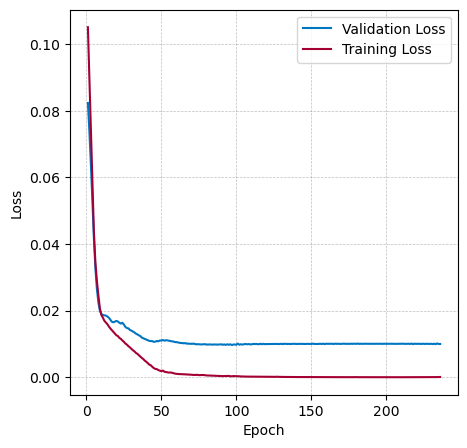

In [106]:
# Building the base model:
model_base_layers = np.empty(shape=(7), dtype=dict,)
model_base_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_base_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_base_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

# Creating the training and testing numpy arrays:
train_base_x = artificial_x
train_base_y = artificial_y

test_base_x = np.empty(shape=(len(test_base_df), 96, 1), dtype=np.int64)
test_base_y = np.empty(shape=(len(test_base_df), 6), dtype=np.float64)

for i, row in test_base_df.iterrows():
    test_base_x[i, :, 0] = row.iloc[1:97].values
    test_base_y[i, :] = row.iloc[97:].values

model_base, recommended_device = create_model(
    model_base_layers,
    tf.keras.optimizers.Adam(learning_rate=7.5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_base.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=25,
        restore_best_weights=True,
    )

    history_base = model_base.fit(
        train_base_x,
        train_base_y,
        epochs=1000,
        validation_data=(test_base_x, test_base_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_base.history["loss"]), len(history_base.history["loss"])),
    history_base.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_base.history["loss"]), len(history_base.history["loss"])),
    history_base.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

model_base.save("model_base.h5")

19/19 [==============================] - 10s 237ms/step - loss: 0.0015 - mean_absolute_error: 0.0255 - val_loss: 0.0105 - val_mean_absolute_error: 0.0495


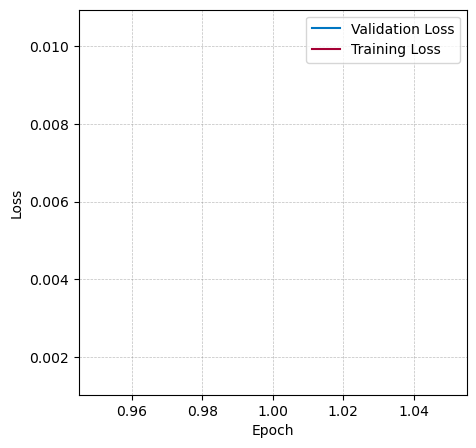

In [116]:
# Retraining model with actual data:
# Creating the training and testing numpy arrays:
# Copying the model_base

model_base_2 = tf.keras.models.load_model("model_base.h5")

train_base_x = np.empty(shape=(len(train_base_df), 96, 1), dtype=np.int64)
train_base_y = np.empty(shape=(len(train_base_df), 6), dtype=np.float64)

for i, row in train_base_df.iterrows():
    train_base_x[i, :, 0] = row.iloc[1:97].values
    train_base_y[i, :] = row.iloc[97:].values

test_base_x = np.empty(shape=(len(test_base_df), 96, 1), dtype=np.int64)
test_base_y = np.empty(shape=(len(test_base_df), 6), dtype=np.float64)

for i, row in test_base_df.iterrows():
    test_base_x[i, :, 0] = row.iloc[1:97].values
    test_base_y[i, :] = row.iloc[97:].values

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=25,
        restore_best_weights=True,
    )

    history_base = model_base_2.fit(
        train_base_x,
        train_base_y,
        epochs=1,
        validation_data=(test_base_x, test_base_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_base.history["loss"]), len(history_base.history["loss"])),
    history_base.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_base.history["loss"]), len(history_base.history["loss"])),
    history_base.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [77]:
model_base_ilum = tf.keras.models.load_model("base-model-illum.h5")


In [108]:

theta_T_vals = [
    test_df["theta_T (deg)"].to_numpy(),
    artificial_df["theta_T"].to_numpy(),
]

temp_vals = [
    test_df.iloc[:, -6:].to_numpy(),
    model_base_ilum.predict(artificial_x, verbose=0) * (max_temp - min_temp) + min_temp,
]
plt_scatter = [True, False,]
colors = [plt_colors[0], plt_colors[1],]
labels = ["Data", "Base model"]
linestyles = [None, "-"],

titles = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"]



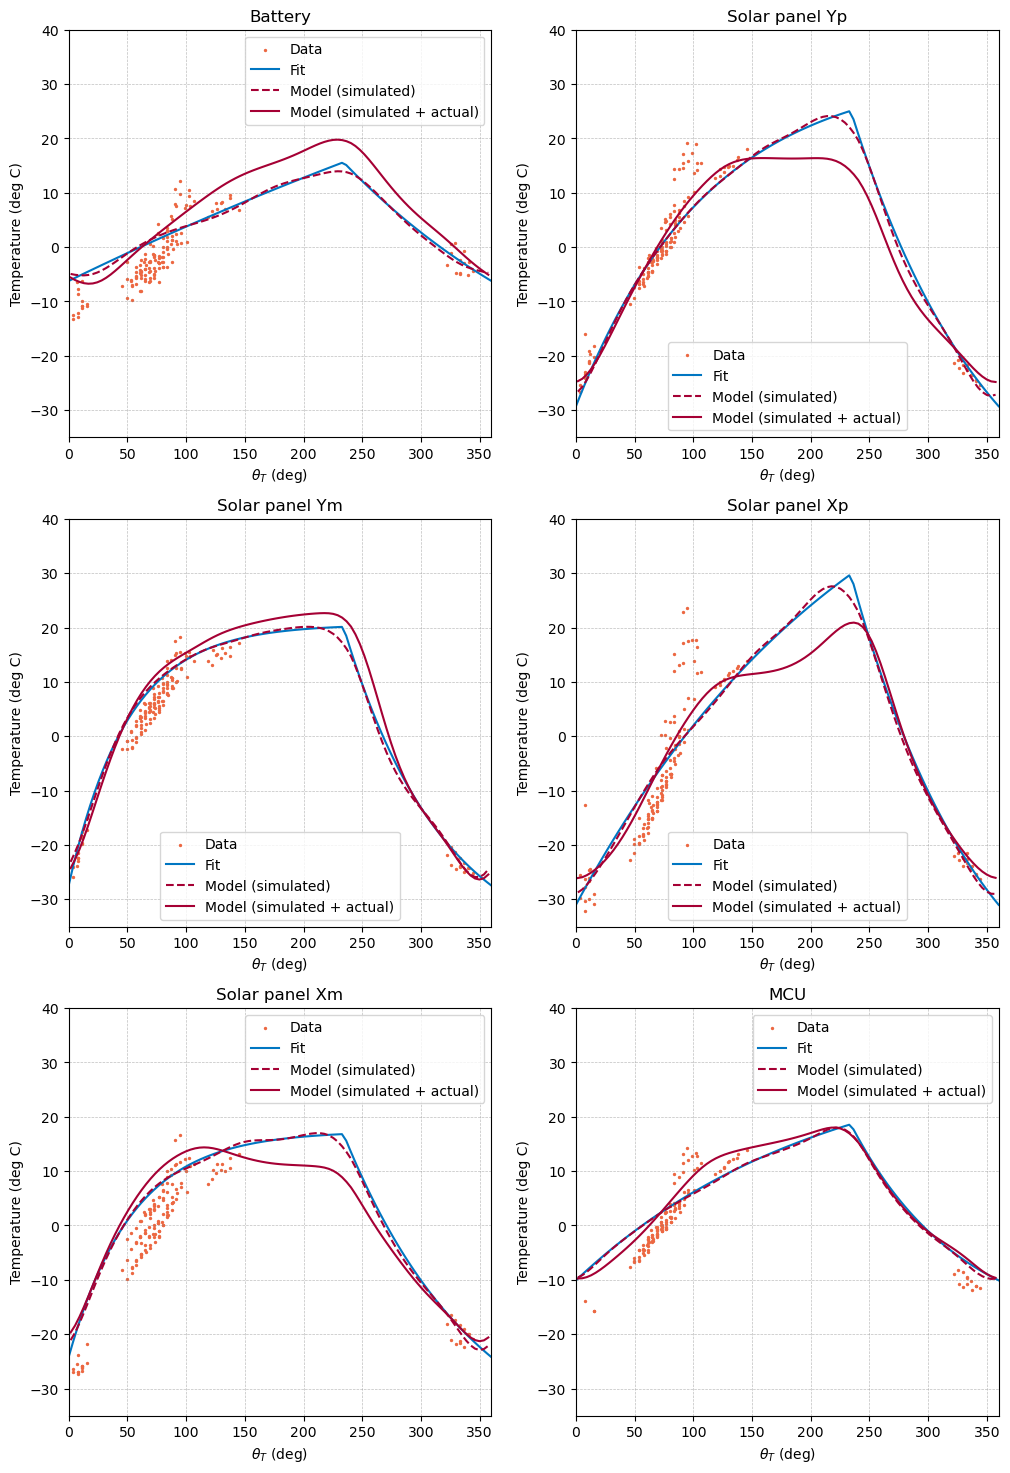

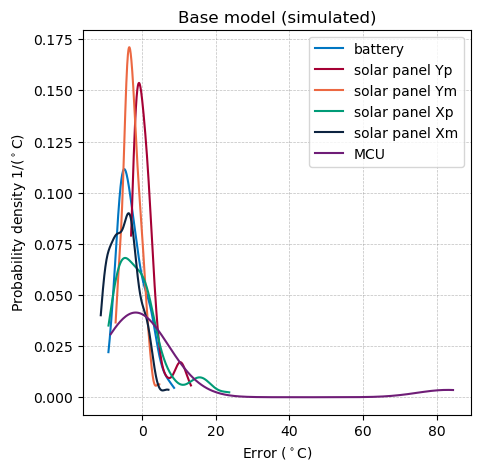

Battery:
Mean: -2.73 degC Std: 3.72 degC (area: 0.97)
Solar panel Yp:
Mean: 0.90 degC Std: 3.45 degC (area: 0.92)
Solar panel Ym:
Mean: -2.83 degC Std: 2.33 degC (area: 0.97)
Solar panel Xp:
Mean: -0.68 degC Std: 6.85 degC (area: 0.93)
Solar panel Xm:
Mean: -4.85 degC Std: 3.92 degC (area: 0.95)
MCU:
Mean: 4.76 degC Std: 22.41 degC (area: 0.77)


Probability of error within 1 degC:
Battery: 0.11
Solar panel Yp: 0.27
Solar panel Ym: 0.15
Solar panel Xp: 0.11
Solar panel Xm: 0.09
MCU: 0.06


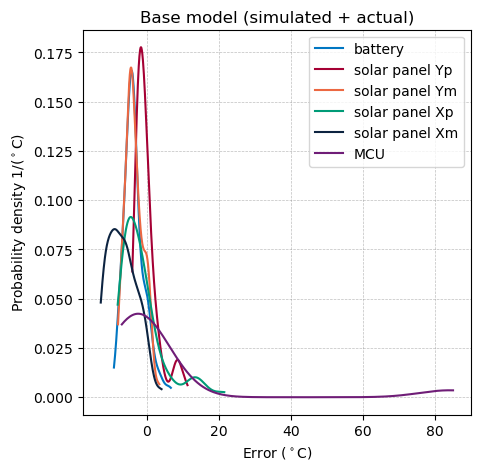

Battery:
Mean: -3.54 degC Std: 2.86 degC (area: 0.98)
Solar panel Yp:
Mean: -0.18 degC Std: 3.18 degC (area: 0.94)
Solar panel Ym:
Mean: -3.55 degC Std: 2.47 degC (area: 0.97)
Solar panel Xp:
Mean: -1.40 degC Std: 6.00 degC (area: 0.92)
Solar panel Xm:
Mean: -6.82 degC Std: 3.93 degC (area: 0.94)
MCU:
Mean: 4.10 degC Std: 22.76 degC (area: 0.69)


Probability of error within 1 degC:
Battery: 0.10
Solar panel Yp: 0.26
Solar panel Ym: 0.13
Solar panel Xp: 0.10
Solar panel Xm: 0.07
MCU: 0.06


In [117]:
theta_T_vals = [
    test_df["theta_T (deg)"].to_numpy(),
    theta_T_fit,
    artificial_df["theta_T"].to_numpy(),
    artificial_df["theta_T"].to_numpy(),
]
temp_vals = [
    test_df.iloc[:, -6:].to_numpy(),
    temp_fit,
    model_base.predict(artificial_x, verbose=0) * (max_temp - min_temp) + min_temp,
    model_base_2.predict(artificial_x, verbose=0) * (max_temp - min_temp) + min_temp,
]
plt_scatter = [True, False, False, False]
colors = [plt_colors[2], plt_colors[0], plt_colors[1], plt_colors[1]]
labels = ["Data", "Fit", "Model (simulated)", "Model (simulated + actual)"]
linestyles = [None, "-", "--", "-"]
titles = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"]

# plot_model(
#     theta_T_data=test_df["theta_T (deg)"].to_numpy(),
#     theta_T_model=artificial_df["theta_T"].to_numpy(),
#     temp_data=test_df.iloc[:, -7:].to_numpy(),
#     temp_model=artificial_y_plot * (max_temp - min_temp) + min_temp,
#     limit_axis=((0, 360), (-35, 35))
# )

# plot_model_v2(
#     theta_T_vals=[telem_df["theta_T (deg)"].to_numpy(), theta_T_fit, theta_T_fit_2],
#     temp_vals=[telem_df.iloc[:, -6:].to_numpy(), temp_fit, temp_fit_2],
#     plt_scatter=[True, False, False],
#     colors=[plt_colors[0], plt_colors[1], plt_colors[2]],
#     labels=["Data", "Fit 1", "Fit 2"],
#     linestyles=[None, "-", "-"],
#     titles = ["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
#     limit_axis=((0, 360), (-35, 40)),
# )

plot_model_v2(
    theta_T_vals=theta_T_vals,
    temp_vals=temp_vals,
    plt_scatter=plt_scatter,
    colors=colors,
    labels=labels,
    linestyles=linestyles,
    titles=titles,
    limit_axis=((0, 360), (-35, 40)),
)

base_stats = kde(
    (test_base_y * (max_temp - min_temp) + min_temp) - (model_base.predict(test_base_x, verbose=0) * (max_temp - min_temp) + min_temp),
    return_stats=True,
    plt_title="Base model (simulated)"
)

base_stats_2 = kde(
    (test_base_y * (max_temp - min_temp) + min_temp) - (model_base_2.predict(test_base_x, verbose=0) * (max_temp - min_temp) + min_temp),
    return_stats=True,
    plt_title="Base model (simulated + actual)"
)

In [43]:
base_predictions_train = model_base_2.predict(train_base_x, verbose=0) * (max_temp - min_temp) + min_temp
base_predictions_test = model_base_2.predict(test_base_x, verbose=0) * (max_temp - min_temp) + min_temp

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 256)               3584      
                                                                 
 dense_82 (Dense)            (None, 256)               65792     
                                                                 
 dense_83 (Dense)            (None, 128)               32896     
                                                                 
 dense_84 (Dense)            (None, 128)               16512     
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 dense_87 (Dense)            (None, 16)              

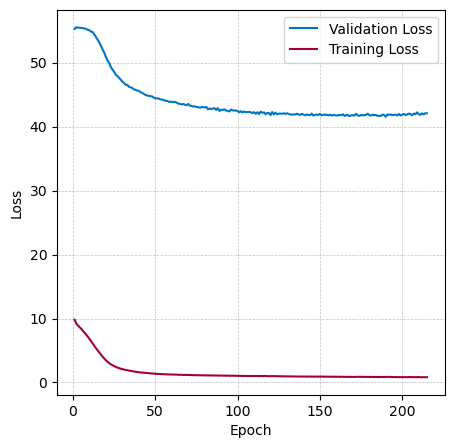

3/3 [==============================] - 0s 2ms/step


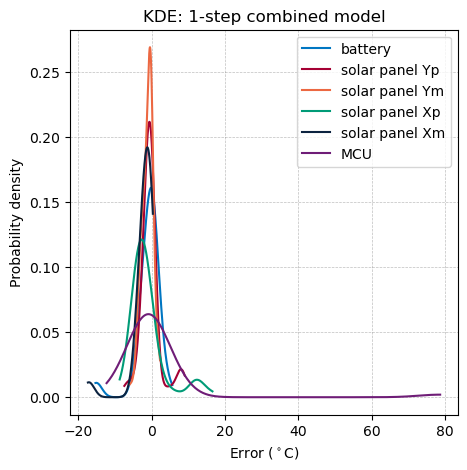

Battery:
Mean: -0.97 degC Std: 3.54 degC (area: 0.97)
Solar panel Yp:
Mean: -0.25 degC Std: 2.93 degC (area: 0.97)
Solar panel Ym:
Mean: -1.15 degC Std: 1.57 degC (area: 0.97)
Solar panel Xp:
Mean: -1.10 degC Std: 4.92 degC (area: 0.97)
Solar panel Xm:
Mean: -2.10 degC Std: 3.42 degC (area: 0.80)
MCU:
Mean: 1.37 degC Std: 13.42 degC (area: 0.95)


Probability of error within 1 degC:
Battery: 0.29
Solar panel Yp: 0.36
Solar panel Ym: 0.42
Solar panel Xp: 0.16
Solar panel Xm: 0.22
MCU: 0.12


In [44]:
# Residual model with window_size = 2
window_size = 1
train_res_6_df = window_data_res(train_df, base_predictions_train, window_size).dropna(how='all').reset_index(drop=True)
train_res_6_x = np.empty(shape=(len(train_res_6_df), 1 + 6 * (window_size + 1)))
train_res_6_y = np.empty(shape=(len(train_res_6_df), 6))

for i in range(len(train_res_6_df)):
    train_res_6_x[i, 0] = train_res_6_df["illumination"][i]
    train_res_6_x[i, 1:(1 + 6 * window_size)] = train_res_6_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_6_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_6_df.iloc[i, -12:-6].values

    train_res_6_y[i, 0:] = train_res_6_df.iloc[i, -6:].values - train_res_6_df.iloc[i, -12:-6].values

test_res_6_df = window_data_res(test_df, base_predictions_test, window_size).dropna(how='all').reset_index(drop=True)
test_res_6_x = np.empty(shape=(len(test_res_6_df), 1 + 6 * (window_size + 1)))
test_res_6_y = np.empty(shape=(len(test_res_6_df), 6))

for i in range(len(test_res_6_df)):
    test_res_6_x[i, 0] = test_res_6_df["illumination"][i]
    test_res_6_x[i, 1:(1 + 6 * window_size)] = test_res_6_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_6_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_6_df.iloc[i, -12:-6].values

    test_res_6_y[i, 0:] = test_res_6_df.iloc[i, -6:].values - test_res_6_df.iloc[i, -12:-6].values


model_res_6, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_6.summary()

with tf.device(recommended_device):
    history_res_6 = model_res_6.fit(
        train_res_6_x,
        train_res_6_y,
        epochs=5000,
        validation_data=(test_res_6_x, test_res_6_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_6.history["loss"]), len(history_res_6.history["loss"])),
    history_res_6.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_6.history["loss"]), len(history_res_6.history["loss"])),
    history_res_6.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the errors from the model:
predicted_res_6 = model_res_6.predict(test_res_6_x)
predicted_temps = test_res_6_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_6
actual_temps = test_res_6_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_6_stats = kde(residuals, plt_title="KDE: 1-step combined model", return_stats=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 256)               5120      
                                                                 
 dense_90 (Dense)            (None, 256)               65792     
                                                                 
 dense_91 (Dense)            (None, 128)               32896     
                                                                 
 dense_92 (Dense)            (None, 128)               16512     
                                                                 
 dense_93 (Dense)            (None, 64)                8256      
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 16)              

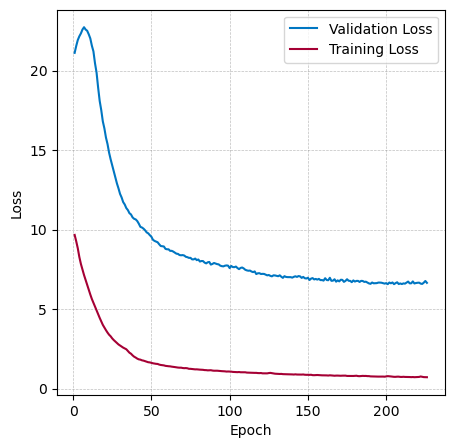

2/2 [==============================] - 0s 3ms/step


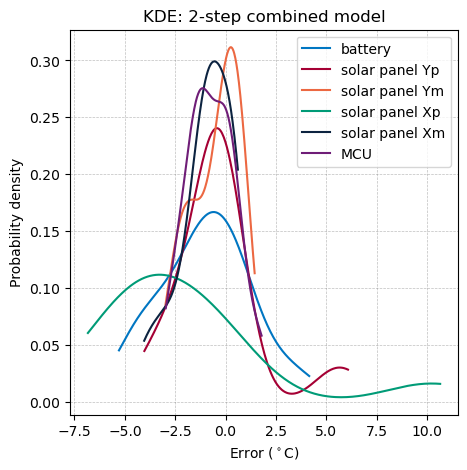

Battery:
Mean: -0.99 degC Std: 2.21 degC (area: 0.94)
Solar panel Yp:
Mean: -0.33 degC Std: 2.19 degC (area: 0.93)
Solar panel Ym:
Mean: -0.54 degC Std: 1.21 degC (area: 0.91)
Solar panel Xp:
Mean: -1.90 degC Std: 4.33 degC (area: 0.86)
Solar panel Xm:
Mean: -0.98 degC Std: 1.28 degC (area: 0.85)
MCU:
Mean: -0.72 degC Std: 1.19 degC (area: 0.93)


Probability of error within 1 degC:
Battery: 0.30
Solar panel Yp: 0.42
Solar panel Ym: 0.53
Solar panel Xp: 0.14
Solar panel Xm: 0.44
MCU: 0.46


In [45]:
# Residual model with window_size = 2
window_size = 2
train_res_7_df = window_data_res(train_df, base_predictions_train, window_size).dropna(how='all').reset_index(drop=True)
train_res_7_x = np.empty(shape=(len(train_res_7_df), 1 + 6 * (window_size + 1)))
train_res_7_y = np.empty(shape=(len(train_res_7_df), 6))

for i in range(len(train_res_7_df)):
    train_res_7_x[i, 0] = train_res_7_df["illumination"][i]
    train_res_7_x[i, 1:(1 + 6 * window_size)] = train_res_7_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_7_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_7_df.iloc[i, -12:-6].values

    train_res_7_y[i, 0:] = train_res_7_df.iloc[i, -6:].values - train_res_7_df.iloc[i, -12:-6].values

test_res_7_df = window_data_res(test_df, base_predictions_test, window_size).dropna(how='all').reset_index(drop=True)
test_res_7_x = np.empty(shape=(len(test_res_7_df), 1 + 6 * (window_size + 1)))
test_res_7_y = np.empty(shape=(len(test_res_7_df), 6))

for i in range(len(test_res_7_df)):
    test_res_7_x[i, 0] = test_res_7_df["illumination"][i]
    test_res_7_x[i, 1:(1 + 6 * window_size)] = test_res_7_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_7_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_7_df.iloc[i, -12:-6].values

    test_res_7_y[i, 0:] = test_res_7_df.iloc[i, -6:].values - test_res_7_df.iloc[i, -12:-6].values


model_res_7, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_7.summary()

with tf.device(recommended_device):
    history_res_7 = model_res_7.fit(
        train_res_7_x,
        train_res_7_y,
        epochs=5000,
        validation_data=(test_res_7_x, test_res_7_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_7.history["loss"]), len(history_res_7.history["loss"])),
    history_res_7.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_7.history["loss"]), len(history_res_7.history["loss"])),
    history_res_7.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the errors from the model:
predicted_res_7 = model_res_7.predict(test_res_7_x)
predicted_temps = test_res_7_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_7
actual_temps = test_res_7_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_7_stats = kde(residuals, plt_title="KDE: 2-step combined model", return_stats=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 256)               6656      
                                                                 
 dense_98 (Dense)            (None, 256)               65792     
                                                                 
 dense_99 (Dense)            (None, 128)               32896     
                                                                 
 dense_100 (Dense)           (None, 128)               16512     
                                                                 
 dense_101 (Dense)           (None, 64)                8256      
                                                                 
 dense_102 (Dense)           (None, 32)                2080      
                                                                 
 dense_103 (Dense)           (None, 16)              

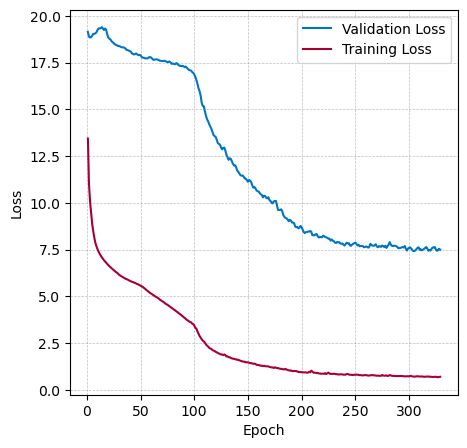

1/1 [==============================] - 0s 83ms/step


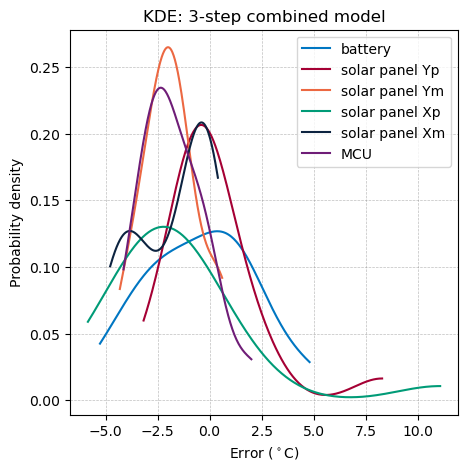

Battery:
Mean: -0.47 degC Std: 2.56 degC (area: 0.91)
Solar panel Yp:
Mean: 0.18 degC Std: 2.35 degC (area: 0.91)
Solar panel Ym:
Mean: -1.86 degC Std: 1.37 degC (area: 0.87)
Solar panel Xp:
Mean: -1.44 degC Std: 3.61 degC (area: 0.87)
Solar panel Xm:
Mean: -1.78 degC Std: 1.80 degC (area: 0.76)
MCU:
Mean: -1.74 degC Std: 1.52 degC (area: 0.90)


Probability of error within 1 degC:
Battery: 0.25
Solar panel Yp: 0.37
Solar panel Ym: 0.20
Solar panel Xp: 0.18
Solar panel Xm: 0.27
MCU: 0.24


In [46]:
# Residual model with window_size = 3
window_size = 3
train_res_8_df = window_data_res(train_df, base_predictions_train, window_size).dropna(how='all').reset_index(drop=True)
train_res_8_x = np.empty(shape=(len(train_res_8_df), 1 + 6 * (window_size + 1)))
train_res_8_y = np.empty(shape=(len(train_res_8_df), 6))

for i in range(len(train_res_8_df)):
    train_res_8_x[i, 0] = train_res_8_df["illumination"][i]
    train_res_8_x[i, 1:(1 + 6 * window_size)] = train_res_8_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_8_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_8_df.iloc[i, -12:-6].values

    train_res_8_y[i, 0:] = train_res_8_df.iloc[i, -6:].values - train_res_8_df.iloc[i, -12:-6].values

test_res_8_df = window_data_res(test_df, base_predictions_test, window_size).dropna(how='all').reset_index(drop=True)
test_res_8_x = np.empty(shape=(len(test_res_8_df), 1 + 6 * (window_size + 1)))
test_res_8_y = np.empty(shape=(len(test_res_8_df), 6))

for i in range(len(test_res_8_df)):
    test_res_8_x[i, 0] = test_res_8_df["illumination"][i]
    test_res_8_x[i, 1:(1 + 6 * window_size)] = test_res_8_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_8_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_8_df.iloc[i, -12:-6].values

    test_res_8_y[i, 0:] = test_res_8_df.iloc[i, -6:].values - test_res_8_df.iloc[i, -12:-6].values


model_res_8, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_8.summary()

with tf.device(recommended_device):
    history_res_8 = model_res_8.fit(
        train_res_8_x,
        train_res_8_y,
        epochs=5000,
        validation_data=(test_res_8_x, test_res_8_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_8.history["loss"]), len(history_res_8.history["loss"])),
    history_res_8.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_8.history["loss"]), len(history_res_8.history["loss"])),
    history_res_8.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the errors from the model:
predicted_res_8 = model_res_8.predict(test_res_8_x)
predicted_temps = test_res_8_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_8
actual_temps = test_res_8_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_8_stats = kde(residuals, plt_title="KDE: 3-step combined model", return_stats=True)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 256)               8192      
                                                                 
 dense_106 (Dense)           (None, 256)               65792     
                                                                 
 dense_107 (Dense)           (None, 128)               32896     
                                                                 
 dense_108 (Dense)           (None, 128)               16512     
                                                                 
 dense_109 (Dense)           (None, 64)                8256      
                                                                 
 dense_110 (Dense)           (None, 32)                2080      
                                                                 
 dense_111 (Dense)           (None, 16)              

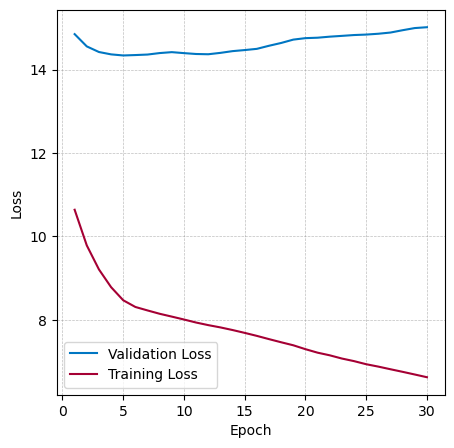

1/1 [==============================] - 0s 92ms/step


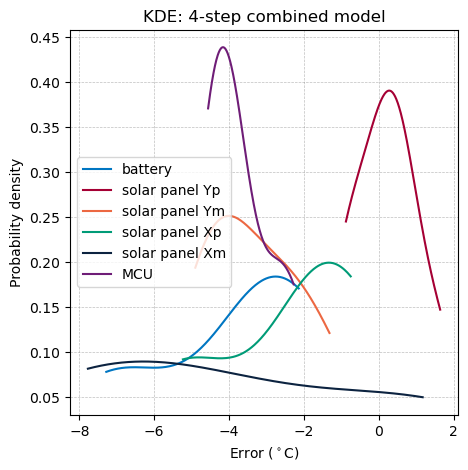

Battery:
Mean: -3.95 degC Std: 1.98 degC (area: 0.63)
Solar panel Yp:
Mean: 0.21 degC Std: 0.81 degC (area: 0.76)
Solar panel Ym:
Mean: -3.35 degC Std: 1.20 degC (area: 0.74)
Solar panel Xp:
Mean: -2.45 degC Std: 1.81 degC (area: 0.61)
Solar panel Xm:
Mean: -4.14 degC Std: 3.51 degC (area: 0.64)
MCU:
Mean: -3.70 degC Std: 0.81 degC (area: 0.69)


Probability of error within 1 degC:
Battery: 0.00
Solar panel Yp: 0.63
Solar panel Ym: 0.00
Solar panel Xp: 0.04
Solar panel Xm: 0.11
MCU: 0.00


In [47]:
# Residual model with window_size = 2
window_size = 4
train_res_9_df = window_data_res(train_df, base_predictions_train, window_size).dropna(how='all').reset_index(drop=True)
train_res_9_x = np.empty(shape=(len(train_res_9_df), 1 + 6 * (window_size + 1)))
train_res_9_y = np.empty(shape=(len(train_res_9_df), 6))

for i in range(len(train_res_9_df)):
    train_res_9_x[i, 0] = train_res_9_df["illumination"][i]
    train_res_9_x[i, 1:(1 + 6 * window_size)] = train_res_9_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_9_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_9_df.iloc[i, -12:-6].values

    train_res_9_y[i, 0:] = train_res_9_df.iloc[i, -6:].values - train_res_9_df.iloc[i, -12:-6].values

test_res_9_df = window_data_res(test_df, base_predictions_test, window_size).dropna(how='all').reset_index(drop=True)
test_res_9_x = np.empty(shape=(len(test_res_9_df), 1 + 6 * (window_size + 1)))
test_res_9_y = np.empty(shape=(len(test_res_9_df), 6))

for i in range(len(test_res_9_df)):
    test_res_9_x[i, 0] = test_res_9_df["illumination"][i]
    test_res_9_x[i, 1:(1 + 6 * window_size)] = test_res_9_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_9_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_9_df.iloc[i, -12:-6].values

    test_res_9_y[i, 0:] = test_res_9_df.iloc[i, -6:].values - test_res_9_df.iloc[i, -12:-6].values


model_res_9, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_9.summary()

with tf.device(recommended_device):
    history_res_9 = model_res_9.fit(
        train_res_9_x,
        train_res_9_y,
        epochs=5000,
        validation_data=(test_res_9_x, test_res_9_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_9.history["loss"]), len(history_res_9.history["loss"])),
    history_res_9.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_9.history["loss"]), len(history_res_9.history["loss"])),
    history_res_9.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the errors from the model:
predicted_res_9 = model_res_9.predict(test_res_9_x)
predicted_temps = test_res_9_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_9
actual_temps = test_res_9_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_9_stats = kde(residuals, plt_title="KDE: 4-step combined model", return_stats=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 256)               9728      
                                                                 
 dense_114 (Dense)           (None, 256)               65792     
                                                                 
 dense_115 (Dense)           (None, 128)               32896     
                                                                 
 dense_116 (Dense)           (None, 128)               16512     
                                                                 
 dense_117 (Dense)           (None, 64)                8256      
                                                                 
 dense_118 (Dense)           (None, 32)                2080      
                                                                 
 dense_119 (Dense)           (None, 16)              

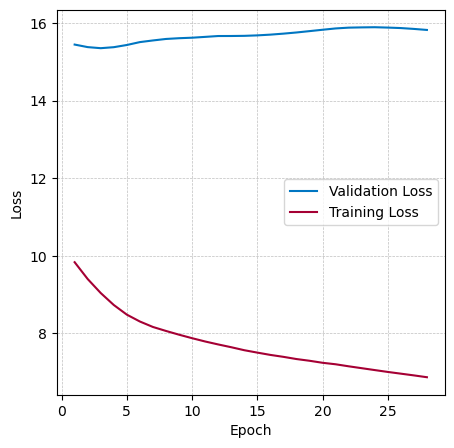

1/1 [==============================] - 0s 82ms/step


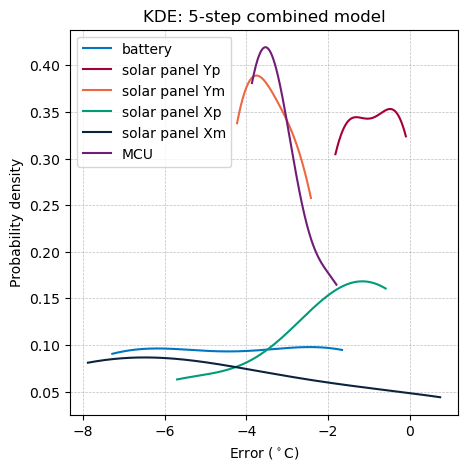

Battery:
Mean: -4.33 degC Std: 2.58 degC (area: 0.53)
Solar panel Yp:
Mean: -0.93 degC Std: 0.72 degC (area: 0.59)
Solar panel Ym:
Mean: -3.42 degC Std: 0.70 degC (area: 0.63)
Solar panel Xp:
Mean: -2.25 degC Std: 2.01 degC (area: 0.58)
Solar panel Xm:
Mean: -4.66 degC Std: 3.46 degC (area: 0.60)
MCU:
Mean: -3.12 degC Std: 0.79 degC (area: 0.61)


Probability of error within 1 degC:
Battery: 0.00
Solar panel Yp: 0.31
Solar panel Ym: 0.00
Solar panel Xp: 0.06
Solar panel Xm: 0.08
MCU: 0.00


In [48]:
# Residual model with window_size = 2
window_size = 5
train_res_10_df = window_data_res(train_df, base_predictions_train, window_size).dropna(how='all').reset_index(drop=True)
train_res_10_x = np.empty(shape=(len(train_res_10_df), 1 + 6 * (window_size + 1)))
train_res_10_y = np.empty(shape=(len(train_res_10_df), 6))

for i in range(len(train_res_10_df)):
    train_res_10_x[i, 0] = train_res_10_df["illumination"][i]
    train_res_10_x[i, 1:(1 + 6 * window_size)] = train_res_10_df.iloc[i, 2:(2 + 6 * window_size)].values
    train_res_10_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = train_res_10_df.iloc[i, -12:-6].values

    train_res_10_y[i, 0:] = train_res_10_df.iloc[i, -6:].values - train_res_10_df.iloc[i, -12:-6].values

test_res_10_df = window_data_res(test_df, base_predictions_test, window_size).dropna(how='all').reset_index(drop=True)
test_res_10_x = np.empty(shape=(len(test_res_10_df), 1 + 6 * (window_size + 1)))
test_res_10_y = np.empty(shape=(len(test_res_10_df), 6))

for i in range(len(test_res_10_df)):
    test_res_10_x[i, 0] = test_res_10_df["illumination"][i]
    test_res_10_x[i, 1:(1 + 6 * window_size)] = test_res_10_df.iloc[i, 2:(2 + 6 * window_size)].values
    test_res_10_x[i, (1 + 6 * window_size):(7 + 6 * window_size)] = test_res_10_df.iloc[i, -12:-6].values

    test_res_10_y[i, 0:] = test_res_10_df.iloc[i, -6:].values - test_res_10_df.iloc[i, -12:-6].values


model_res_10, recommended_device = create_model(
    model_res_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=((1 + 6 * (window_size + 1),)),
    output_shape=6,
)

model_res_10.summary()

with tf.device(recommended_device):
    history_res_10 = model_res_10.fit(
        train_res_10_x,
        train_res_10_y,
        epochs=5000,
        validation_data=(test_res_10_x, test_res_10_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_res_10.history["loss"]), len(history_res_10.history["loss"])),
    history_res_10.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_res_10.history["loss"]), len(history_res_10.history["loss"])),
    history_res_10.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the errors from the model:
predicted_res_10 = model_res_10.predict(test_res_10_x)
predicted_temps = test_res_10_df.iloc[:, -12:-6].to_numpy(dtype=np.float64) + predicted_res_10
actual_temps = test_res_10_df.iloc[:, -6:].to_numpy(dtype=np.float64)

residuals = actual_temps - predicted_temps
res_10_stats = kde(residuals, plt_title="KDE: 5-step combined model", return_stats=True)

In [49]:
print("Base models (test set):")
print("Mean (deg C)")
print(f"Curve fit: {np.mean(test_stats[0][0]):.2f}; Base mode (simulated): {np.mean(base_stats[0][0]):.2f}; Base model (simulated + actual): {np.mean(base_stats_2[0][0]):.2f}")
print("Standard deviation (deg C)")
print(f"Curve fit: {np.mean(test_stats[0][1]):.2f}; Base mode (simulated): {np.mean(base_stats[0][1]):.2f}; Base model (simulated + actual): {np.mean(base_stats_2[0][1]):.2f}")

Base models (test set):
Mean (deg C)
Curve fit: -0.75; Base mode (simulated): -1.21; Base model (simulated + actual): -1.43
Standard deviation (deg C)
Curve fit: 6.88; Base mode (simulated): 6.89; Base model (simulated + actual): 6.79


In [50]:
test_stats = np.array(test_stats[0])
base_stats = np.array(base_stats[0])
base_stats_2 = np.array(base_stats_2[0])
res_1_stats = np.array(res_1_stats[0])
res_2_stats = np.array(res_2_stats[0])
res_3_stats = np.array(res_3_stats[0])
res_4_stats = np.array(res_4_stats[0])
res_5_stats = np.array(res_5_stats[0])

res_1_norm_stats = np.array(res_1_norm_stats[0])
res_2_norm_stats = np.array(res_2_norm_stats[0])
res_3_norm_stats = np.array(res_3_norm_stats[0])
res_4_norm_stats = np.array(res_4_norm_stats[0])
res_5_norm_stats = np.array(res_5_norm_stats[0])

res_6_stats = np.array(res_6_stats[0])
res_7_stats = np.array(res_7_stats[0])
res_8_stats = np.array(res_8_stats[0])
res_9_stats = np.array(res_9_stats[0])
res_10_stats = np.array(res_10_stats[0])


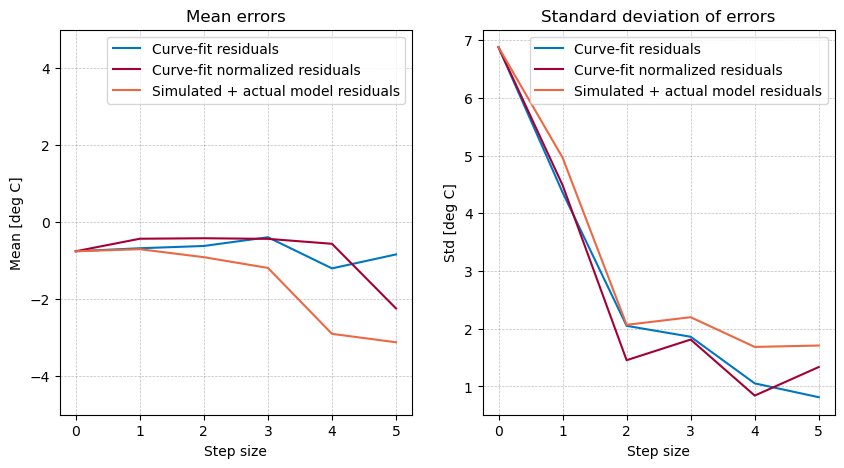

In [51]:
# Plotting the stats:
plot_x = [0, 1, 2, 3, 4, 5]
plot_y_mean_res = np.empty(shape=(6, 6))
plot_y_std_res = np.empty(shape=(6, 6))

plot_y_mean_res[0] = test_stats[0]
plot_y_mean_res[1] = res_1_stats[0]
plot_y_mean_res[2] = res_2_stats[0]
plot_y_mean_res[3] = res_3_stats[0]
plot_y_mean_res[4] = res_4_stats[0]
plot_y_mean_res[5] = res_5_stats[0]

plot_y_std_res[0] = test_stats[1]
plot_y_std_res[1] = res_1_stats[1]
plot_y_std_res[2] = res_2_stats[1]
plot_y_std_res[3] = res_3_stats[1]
plot_y_std_res[4] = res_4_stats[1]
plot_y_std_res[5] = res_5_stats[1]

plot_y_mean_res_1 = np.empty(shape=(6, 6))
plot_y_std_res_1 = np.empty(shape=(6, 6))

plot_y_mean_res_1[0] = test_stats[0]
plot_y_mean_res_1[1] = res_1_norm_stats[0]
plot_y_mean_res_1[2] = res_2_norm_stats[0]
plot_y_mean_res_1[3] = res_3_norm_stats[0]
plot_y_mean_res_1[4] = res_4_norm_stats[0]
plot_y_mean_res_1[5] = res_5_norm_stats[0]

plot_y_std_res_1[0] = test_stats[1]
plot_y_std_res_1[1] = res_1_norm_stats[1]
plot_y_std_res_1[2] = res_2_norm_stats[1]
plot_y_std_res_1[3] = res_3_norm_stats[1]
plot_y_std_res_1[4] = res_4_norm_stats[1]
plot_y_std_res_1[5] = res_5_norm_stats[1]

plot_y_mean_res_2 = np.empty(shape=(6, 6))
plot_y_std_res_2 = np.empty(shape=(6, 6))

plot_y_mean_res_2[0] = test_stats[0]
plot_y_mean_res_2[1] = res_6_stats[0]
plot_y_mean_res_2[2] = res_7_stats[0]
plot_y_mean_res_2[3] = res_8_stats[0]
plot_y_mean_res_2[4] = res_9_stats[0]
plot_y_mean_res_2[5] = res_10_stats[0]

plot_y_std_res_2[0] = test_stats[1]
plot_y_std_res_2[1] = res_6_stats[1]
plot_y_std_res_2[2] = res_7_stats[1]
plot_y_std_res_2[3] = res_8_stats[1]
plot_y_std_res_2[4] = res_9_stats[1]
plot_y_std_res_2[5] = res_10_stats[1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res, axis=1),
    color=plt_colors[0],
    label="Curve-fit residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res_1, axis=1),
    color=plt_colors[1],
    label="Curve-fit normalized residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res_2, axis=1),
    color=plt_colors[2],
    label="Simulated + actual model residuals"
)
plt.legend()
plt.title("Mean errors")
plt.ylabel("Mean [deg C]")
plt.xlabel("Step size")
plt.grid()
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res, axis=1),
    color=plt_colors[0],
    label="Curve-fit residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res_1, axis=1),
    color=plt_colors[1],
    label="Curve-fit normalized residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res_2, axis=1),
    color=plt_colors[2],
    label="Simulated + actual model residuals"
)
plt.legend()
plt.title("Standard deviation of errors")
plt.ylabel("Std [deg C]")
plt.xlabel("Step size")
plt.grid()

plt.show()


In [118]:
# Plotting the stats:
plot_x = [0, 1, 2, 3, 4, 5]
plot_y_mean_res = np.empty(shape=(6, 6))
plot_y_std_res = np.empty(shape=(6, 6))

plot_y_mean_res[0] = test_stats[0]
plot_y_mean_res[1] = res_1_stats[0]
plot_y_mean_res[2] = res_2_stats[0]
plot_y_mean_res[3] = res_3_stats[0]
plot_y_mean_res[4] = res_4_stats[0]
plot_y_mean_res[5] = res_5_stats[0]

plot_y_std_res[0] = test_stats[1]
plot_y_std_res[1] = res_1_stats[1]
plot_y_std_res[2] = res_2_stats[1]
plot_y_std_res[3] = res_3_stats[1]
plot_y_std_res[4] = res_4_stats[1]
plot_y_std_res[5] = res_5_stats[1]

plot_y_mean_res_1 = np.empty(shape=(6, 6))
plot_y_std_res_1 = np.empty(shape=(6, 6))

plot_y_mean_res_1[0] = test_stats[0]
plot_y_mean_res_1[1] = res_1_norm_stats[0]
plot_y_mean_res_1[2] = res_2_norm_stats[0]
plot_y_mean_res_1[3] = res_3_norm_stats[0]
plot_y_mean_res_1[4] = res_4_norm_stats[0]
plot_y_mean_res_1[5] = res_5_norm_stats[0]

plot_y_std_res_1[0] = test_stats[1]
plot_y_std_res_1[1] = res_1_norm_stats[1]
plot_y_std_res_1[2] = res_2_norm_stats[1]
plot_y_std_res_1[3] = res_3_norm_stats[1]
plot_y_std_res_1[4] = res_4_norm_stats[1]
plot_y_std_res_1[5] = res_5_norm_stats[1]

plot_y_mean_res_2 = np.empty(shape=(6, 6))
plot_y_std_res_2 = np.empty(shape=(6, 6))

plot_y_mean_res_2[0] = test_stats[0]
plot_y_mean_res_2[1] = res_6_stats[0]
plot_y_mean_res_2[2] = res_7_stats[0]
plot_y_mean_res_2[3] = res_8_stats[0]
plot_y_mean_res_2[4] = res_9_stats[0]
plot_y_mean_res_2[5] = res_10_stats[0]

plot_y_std_res_2[0] = test_stats[1]
plot_y_std_res_2[1] = res_6_stats[1]
plot_y_std_res_2[2] = res_7_stats[1]
plot_y_std_res_2[3] = res_8_stats[1]
plot_y_std_res_2[4] = res_9_stats[1]
plot_y_std_res_2[5] = res_10_stats[1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res, axis=1),
    color=plt_colors[0],
    label="Curve-fit residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res_1, axis=1),
    color=plt_colors[1],
    label="Curve-fit normalized residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_mean_res_2, axis=1),
    color=plt_colors[2],
    label="Simulated + actual model residuals"
)
plt.legend()
plt.title("Mean errors")
plt.ylabel("Mean [deg C]")
plt.xlabel("Step size")
plt.grid()
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res, axis=1),
    color=plt_colors[0],
    label="Curve-fit residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res_1, axis=1),
    color=plt_colors[1],
    label="Curve-fit normalized residuals"
)
plt.plot(
    plot_x,
    np.mean(plot_y_std_res_2, axis=1),
    color=plt_colors[2],
    label="Simulated + actual model residuals"
)
plt.legend()
plt.title("Standard deviation of errors")
plt.ylabel("Std [deg C]")
plt.xlabel("Step size")
plt.grid()

plt.show()


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.